In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, concat_ws, to_timestamp, date_format, size, split
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

from pyspark.ml.clustering import KMeans, KMeansModel
from pyspark.ml.feature import VectorAssembler


In [2]:
#Read csv file to dataframe
spark = SparkSession.builder.getOrCreate()
df = spark.read.csv("crash_weather.csv", inferSchema=True, header=True)

df.show(1)

+-------------------+--------+--------+---------+---------+--------------------+--------------------+-------------------------+------------------------+-----------------------------+----------------------------+-------------------------+------------------------+--------------------------+-------------------------+------------+-------------------+-------------------+-------------------+------------------+---------+--------------+------------------+------------------+-------------------+--------------------+---------------------+-------------------+-----------------+--------------+-----------------+
|          simp_date| borough|zip code| latitude|longitude|            location|     off street name|number of persons injured|number of persons killed|number of pedestrians injured|number of pedestrians killed|number of cyclist injured|number of cyclist killed|number of motorist injured|number of motorist killed|collision_id|               date|               time|temperature_2m (°C)|precipi

In [3]:
df1 = df.select("simp_date", "latitude", "longitude", "borough")
df1.show(3)

+-------------------+---------+---------+--------+
|          simp_date| latitude|longitude| borough|
+-------------------+---------+---------+--------+
|2021-09-11 09:00:00|40.667202| -73.8665|BROOKLYN|
|2021-12-14 08:00:00| 40.86816|-73.83148|   BRONX|
|2021-12-14 21:00:00| 40.67172| -73.8971|BROOKLYN|
+-------------------+---------+---------+--------+
only showing top 3 rows



In [4]:
df1 = df1.withColumn('time', split(df['simp_date'], ' ').getItem(1))
df1 = df1.drop('simp_date')
df1.show(truncate=False)
df1.printSchema()

+------------------+----------+-------------+--------+
|latitude          |longitude |borough      |time    |
+------------------+----------+-------------+--------+
|40.667202         |-73.8665  |BROOKLYN     |09:00:00|
|40.86816          |-73.83148 |BRONX        |08:00:00|
|40.67172          |-73.8971  |BROOKLYN     |21:00:00|
|40.75144          |-73.97397 |MANHATTAN    |14:00:00|
|40.675883999999996|-73.75577 |QUEENS       |16:00:00|
|40.66684          |-73.78941 |QUEENS       |23:00:00|
|40.68158          |-73.97463 |BROOKLYN     |17:00:00|
|40.65068          |-73.95881 |BROOKLYN     |20:00:00|
|40.87262          |-73.904686|BRONX        |19:00:00|
|40.748917         |-73.993546|MANHATTAN    |04:00:00|
|40.75373          |-73.88505 |QUEENS       |06:00:00|
|40.63165          |-74.08762 |STATEN ISLAND|17:00:00|
|40.623104         |-73.95809 |BROOKLYN     |17:00:00|
|40.66576          |-73.9845  |BROOKLYN     |20:00:00|
|40.687534         |-73.9775  |BROOKLYN     |12:00:00|
|40.710957

### 00:00

In [5]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='00:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="MANHATTAN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+---------+--------+--------------------+
| latitude| longitude|  borough|    time|            features|
+---------+----------+---------+--------+--------------------+
|40.805138|-73.945244|MANHATTAN|00:00:00|[40.805138,-73.94...|
| 40.80641| -73.94227|MANHATTAN|00:00:00|[40.80641,-73.94227]|
|40.832764| -73.94583|MANHATTAN|00:00:00|[40.832764,-73.94...|
|40.800663|-73.946465|MANHATTAN|00:00:00|[40.800663,-73.94...|
|40.737568| -74.00149|MANHATTAN|00:00:00|[40.737568,-74.00...|
|40.747276|-73.989624|MANHATTAN|00:00:00|[40.747276,-73.98...|
|40.800262| -73.94554|MANHATTAN|00:00:00|[40.800262,-73.94...|
|  40.7171|  -73.9986|MANHATTAN|00:00:00|  [40.7171,-73.9986]|
|40.723507| -73.98541|MANHATTAN|00:00:00|[40.723507,-73.98...|
|40.745384| -73.99471|MANHATTAN|00:00:00|[40.745384,-73.99...|
|40.867107| -73.92283|MANHATTAN|00:00:00|[40.867107,-73.92...|
|40.802753| -73.93358|MANHATTAN|00:00:00|[40.802753,-73.93...|
|40.801918| -73.94344|MANHATTAN|00:00:00|[40.801918,-73

In [6]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+---------+--------+--------------------+----------+
| latitude| longitude|  borough|    time|            features|prediction|
+---------+----------+---------+--------+--------------------+----------+
|40.805138|-73.945244|MANHATTAN|00:00:00|[40.805138,-73.94...|        18|
| 40.80641| -73.94227|MANHATTAN|00:00:00|[40.80641,-73.94227]|        18|
|40.832764| -73.94583|MANHATTAN|00:00:00|[40.832764,-73.94...|         1|
|40.800663|-73.946465|MANHATTAN|00:00:00|[40.800663,-73.94...|        18|
|40.737568| -74.00149|MANHATTAN|00:00:00|[40.737568,-74.00...|         6|
|40.747276|-73.989624|MANHATTAN|00:00:00|[40.747276,-73.98...|         6|
|40.800262| -73.94554|MANHATTAN|00:00:00|[40.800262,-73.94...|        18|
|  40.7171|  -73.9986|MANHATTAN|00:00:00|  [40.7171,-73.9986]|        12|
|40.723507| -73.98541|MANHATTAN|00:00:00|[40.723507,-73.98...|         3|
|40.745384| -73.99471|MANHATTAN|00:00:00|[40.745384,-73.99...|         6|
|40.867107| -73.92283|MANHATTAN|00:00:

Text(0.5, 1.0, 'MANHATTAN_00:00')

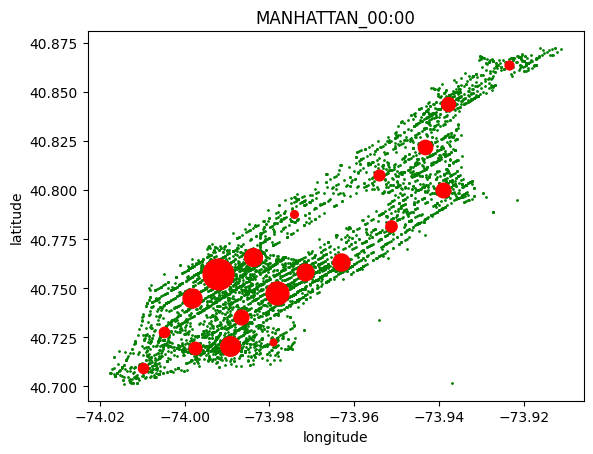

In [7]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.9:
        if i[0]>40.70 and i[0]<40.90:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if j[1]>-74.05 and j[1]<-73.9:
        if j[0]>40.70 and j[0]<40.90:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("MANHATTAN_00:00")

In [8]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.757076416641674, -73.99216646341829, 664],
 [40.821945325000016, -73.94340438376624, 311],
 [40.863612813402064, -73.92338522371134, 192],
 [40.7203593672209, -73.98931043040382, 421],
 [40.763193942119564, -73.96309623043479, 369],
 [40.84404015233333, -73.93776797666668, 299],
 [40.74492270855746, -73.99820112444988, 409],
 [40.73510234827586, -73.98660122006268, 319],
 [40.72240648819444, -73.97910239861112, 144],
 [40.76598848193718, -73.98388347277488, 385],
 [40.70956292718894, -74.00974371013824, 217],
 [40.78188560040984, -73.95131927049182, 245],
 [40.7196972701107, -73.99743722619925, 271],
 [40.75822530831025, -73.97156212243766, 361],
 [40.80784914482758, -73.95415229310345, 233],
 [40.78784831867471, -73.97421564216867, 166],
 [40.72793650990992, -74.00483928783784, 222],
 [40.74751350080971, -73.97824850668016, 494],
 [40.80016136355139, -73.9390331719626, 318],
 [40.692705000000004, -73.794883, 2]]

### 01:00

In [9]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='01:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="MANHATTAN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+---------+--------+--------------------+
| latitude| longitude|  borough|    time|            features|
+---------+----------+---------+--------+--------------------+
|40.797836| -73.96946|MANHATTAN|01:00:00|[40.797836,-73.96...|
|40.761486| -73.96061|MANHATTAN|01:00:00|[40.761486,-73.96...|
|40.860664| -73.92171|MANHATTAN|01:00:00|[40.860664,-73.92...|
| 40.77161| -73.99046|MANHATTAN|01:00:00|[40.77161,-73.99046]|
|40.764626| -73.99555|MANHATTAN|01:00:00|[40.764626,-73.99...|
|40.766144| -73.99724|MANHATTAN|01:00:00|[40.766144,-73.99...|
| 40.73736| -73.99685|MANHATTAN|01:00:00|[40.73736,-73.99685]|
|40.848118| -73.93089|MANHATTAN|01:00:00|[40.848118,-73.93...|
| 40.77077|-73.980675|MANHATTAN|01:00:00|[40.77077,-73.980...|
|40.750988| -73.99063|MANHATTAN|01:00:00|[40.750988,-73.99...|
|  40.8037| -73.93582|MANHATTAN|01:00:00| [40.8037,-73.93582]|
|40.809605| -73.94981|MANHATTAN|01:00:00|[40.809605,-73.94...|
|40.720375|-74.003265|MANHATTAN|01:00:00|[40.720375,-74

In [10]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+---------+--------+--------------------+----------+
| latitude| longitude|  borough|    time|            features|prediction|
+---------+----------+---------+--------+--------------------+----------+
|40.797836| -73.96946|MANHATTAN|01:00:00|[40.797836,-73.96...|        12|
|40.761486| -73.96061|MANHATTAN|01:00:00|[40.761486,-73.96...|         5|
|40.860664| -73.92171|MANHATTAN|01:00:00|[40.860664,-73.92...|         1|
| 40.77161| -73.99046|MANHATTAN|01:00:00|[40.77161,-73.99046]|        14|
|40.764626| -73.99555|MANHATTAN|01:00:00|[40.764626,-73.99...|        19|
|40.766144| -73.99724|MANHATTAN|01:00:00|[40.766144,-73.99...|        19|
| 40.73736| -73.99685|MANHATTAN|01:00:00|[40.73736,-73.99685]|        15|
|40.848118| -73.93089|MANHATTAN|01:00:00|[40.848118,-73.93...|        11|
| 40.77077|-73.980675|MANHATTAN|01:00:00|[40.77077,-73.980...|        14|
|40.750988| -73.99063|MANHATTAN|01:00:00|[40.750988,-73.99...|         8|
|  40.8037| -73.93582|MANHATTAN|01:00:

Text(0.5, 1.0, 'MANHATTAN_01:00')

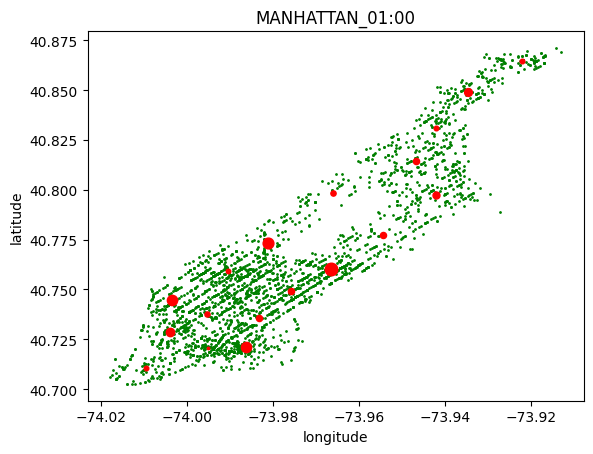

In [11]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.9:
        if i[0]>40.70 and i[0]<40.90:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if j[1]>-74.05 and j[1]<-73.9:
        if j[0]>40.70 and j[0]<40.90:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("MANHATTAN_01:00")

In [12]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.735694551879696, -73.9832396857143, 133],
 [40.86467893168316, -73.92208123762377, 101],
 [40.79765230529802, -73.94209525099339, 151],
 [40.721183337104065, -73.98630346289595, 221],
 [40.710368515, -74.009640055, 100],
 [40.76045004375, -73.96643562977941, 272],
 [40.83082118, -73.942018083, 101],
 [40.674, -73.8721, 1],
 [40.747879770165746, -73.98879184585634, 181],
 [40.728434768148155, -74.00397575407408, 134],
 [40.81431759580839, -73.94668121257484, 169],
 [40.84930596140351, -73.9345927105263, 114],
 [40.798563696428566, -73.96606887321428, 54],
 [40.72054168283261, -73.99521842403432, 233],
 [40.77311534339623, -73.9810889235849, 112],
 [40.73761338496241, -73.99545654135336, 134],
 [40.74939949684685, -73.97577577882883, 222],
 [40.7448698439394, -74.00357374545455, 132],
 [40.77723769285714, -73.95448128163264, 98],
 [40.75939833144653, -73.99050950503145, 311]]

### 02:00

In [13]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='02:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="MANHATTAN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+---------+--------+--------------------+
| latitude| longitude|  borough|    time|            features|
+---------+----------+---------+--------+--------------------+
|40.754707| -73.99164|MANHATTAN|02:00:00|[40.754707,-73.99...|
|40.718826| -73.98424|MANHATTAN|02:00:00|[40.718826,-73.98...|
|40.830845|-73.947235|MANHATTAN|02:00:00|[40.830845,-73.94...|
| 40.85019|-73.939644|MANHATTAN|02:00:00|[40.85019,-73.939...|
|40.802753| -73.93358|MANHATTAN|02:00:00|[40.802753,-73.93...|
| 40.74005| -73.99915|MANHATTAN|02:00:00|[40.74005,-73.99915]|
| 40.82803|-73.934845|MANHATTAN|02:00:00|[40.82803,-73.934...|
|40.825138|  -73.9514|MANHATTAN|02:00:00|[40.825138,-73.9514]|
| 40.75398| -73.99373|MANHATTAN|02:00:00|[40.75398,-73.99373]|
|40.788357| -73.97453|MANHATTAN|02:00:00|[40.788357,-73.97...|
|40.742107| -73.98075|MANHATTAN|02:00:00|[40.742107,-73.98...|
|40.718456| -73.99482|MANHATTAN|02:00:00|[40.718456,-73.99...|
|40.736996|-73.998146|MANHATTAN|02:00:00|[40.736996,-73

In [14]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+---------+--------+--------------------+----------+
| latitude| longitude|  borough|    time|            features|prediction|
+---------+----------+---------+--------+--------------------+----------+
|40.754707| -73.99164|MANHATTAN|02:00:00|[40.754707,-73.99...|         7|
|40.718826| -73.98424|MANHATTAN|02:00:00|[40.718826,-73.98...|        10|
|40.830845|-73.947235|MANHATTAN|02:00:00|[40.830845,-73.94...|         4|
| 40.85019|-73.939644|MANHATTAN|02:00:00|[40.85019,-73.939...|         8|
|40.802753| -73.93358|MANHATTAN|02:00:00|[40.802753,-73.93...|        15|
| 40.74005| -73.99915|MANHATTAN|02:00:00|[40.74005,-73.99915]|         5|
| 40.82803|-73.934845|MANHATTAN|02:00:00|[40.82803,-73.934...|         4|
|40.825138|  -73.9514|MANHATTAN|02:00:00|[40.825138,-73.9514]|         4|
| 40.75398| -73.99373|MANHATTAN|02:00:00|[40.75398,-73.99373]|         7|
|40.788357| -73.97453|MANHATTAN|02:00:00|[40.788357,-73.97...|        18|
|40.742107| -73.98075|MANHATTAN|02:00:

Text(0.5, 1.0, 'MANHATTAN_02:00')

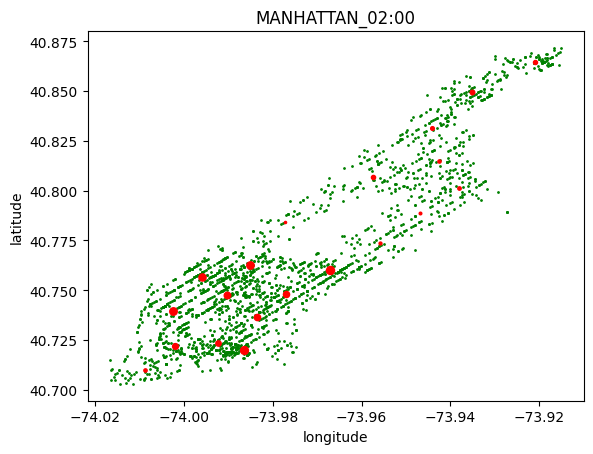

In [15]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.9:
        if i[0]>40.70 and i[0]<40.90:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if j[1]>-74.05 and j[1]<-73.9:
        if j[0]>40.70 and j[0]<40.90:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("MANHATTAN_02:00")

In [16]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.748272293233086, -73.97707503984962, 134],
 [40.86468292954545, -73.92101143522726, 88],
 [40.723732213793106, -73.99244092155173, 116],
 [40.762482419875774, -73.98522601863354, 160],
 [40.83120625875, -73.9440728525, 80],
 [40.73952771975308, -74.0025431808642, 162],
 [40.806894453333335, -73.95740387555557, 90],
 [40.756680030967736, -73.99603404774194, 155],
 [40.84949553939395, -73.9351051141414, 99],
 [40.773577682539674, -73.95591531904762, 63],
 [40.72014484529411, -73.9865274017647, 170],
 [40.72188771825397, -74.00213911587299, 126],
 [40.81489152571429, -73.94248515857143, 70],
 [40.7366686125, -73.98356497205882, 136],
 [40.78854818070175, -73.94691145438595, 57],
 [40.801256486486494, -73.93813843783785, 74],
 [40.76005687413793, -73.96717182816091, 174],
 [40.709798930555564, -74.0087528611111, 72],
 [40.784469631914895, -73.97736585106384, 47],
 [40.747352876760566, -73.99024892464789, 142]]

### 03:00

In [17]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='03:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="MANHATTAN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+------------------+----------+---------+--------+--------------------+
|          latitude| longitude|  borough|    time|            features|
+------------------+----------+---------+--------+--------------------+
|         40.805058| -73.93904|MANHATTAN|03:00:00|[40.805058,-73.93...|
|         40.731125|-74.004234|MANHATTAN|03:00:00|[40.731125,-74.00...|
|         40.800507|-73.938156|MANHATTAN|03:00:00|[40.800507,-73.93...|
|         40.808407| -73.95248|MANHATTAN|03:00:00|[40.808407,-73.95...|
|          40.80844|  -73.9471|MANHATTAN|03:00:00| [40.80844,-73.9471]|
|          40.75633| -73.98767|MANHATTAN|03:00:00|[40.75633,-73.98767]|
|           40.7491| -73.99201|MANHATTAN|03:00:00| [40.7491,-73.99201]|
|          40.76734| -73.96868|MANHATTAN|03:00:00|[40.76734,-73.96868]|
|         40.821815| -73.94266|MANHATTAN|03:00:00|[40.821815,-73.94...|
|          40.71843|-74.000534|MANHATTAN|03:00:00|[40.71843,-74.000...|
|         40.821144| -73.95753|MANHATTAN|03:00:00|[40.821144,-73

In [18]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+------------------+----------+---------+--------+--------------------+----------+
|          latitude| longitude|  borough|    time|            features|prediction|
+------------------+----------+---------+--------+--------------------+----------+
|         40.805058| -73.93904|MANHATTAN|03:00:00|[40.805058,-73.93...|        18|
|         40.731125|-74.004234|MANHATTAN|03:00:00|[40.731125,-74.00...|         1|
|         40.800507|-73.938156|MANHATTAN|03:00:00|[40.800507,-73.93...|         6|
|         40.808407| -73.95248|MANHATTAN|03:00:00|[40.808407,-73.95...|        12|
|          40.80844|  -73.9471|MANHATTAN|03:00:00| [40.80844,-73.9471]|        18|
|          40.75633| -73.98767|MANHATTAN|03:00:00|[40.75633,-73.98767]|        19|
|           40.7491| -73.99201|MANHATTAN|03:00:00| [40.7491,-73.99201]|         8|
|          40.76734| -73.96868|MANHATTAN|03:00:00|[40.76734,-73.96868]|         7|
|         40.821815| -73.94266|MANHATTAN|03:00:00|[40.821815,-73.94...|         5|
|   

Text(0.5, 1.0, 'MANHATTAN_03:00')

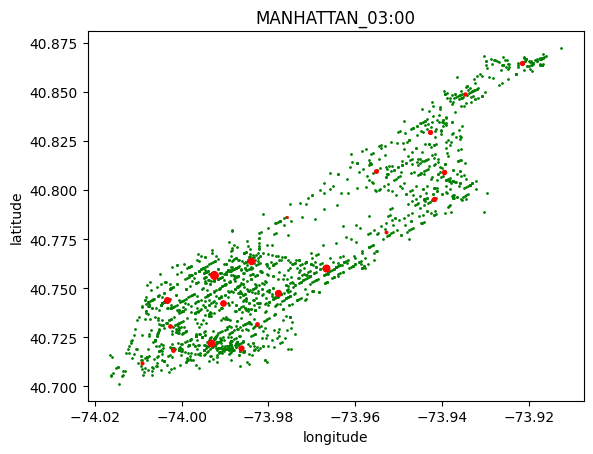

In [19]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.9:
        if i[0]>40.70 and i[0]<40.90:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if j[1]>-74.05 and j[1]<-73.9:
        if j[0]>40.70 and j[0]<40.90:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("MANHATTAN_03:00")

In [20]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.786384709375, -73.97564330312501, 32],
 [40.73059450138889, -74.00270492083334, 72],
 [40.864557547058816, -73.92147644352941, 85],
 [40.71873321600001, -74.00187981333335, 75],
 [40.73180894594595, -73.98256134864864, 74],
 [40.82933606024096, -73.94285092771084, 83],
 [40.79543548941176, -73.9417614188235, 85],
 [40.76030670489511, -73.96673593496503, 143],
 [40.7426005826087, -73.99056148347826, 115],
 [40.747473529133856, -73.97772227716536, 127],
 [40.744045179508205, -74.00336522049182, 122],
 [40.764060306923085, -73.98406519846154, 130],
 [40.80958070129871, -73.95522052207794, 77],
 [40.72199532086331, -73.99314206834532, 139],
 [40.84906595454545, -73.93481213181819, 66],
 [40.77879346964285, -73.95295494642856, 56],
 [40.71172516271185, -74.00918670508473, 59],
 [40.719682761904764, -73.98626774380953, 105],
 [40.80913509318183, -73.93958236590909, 88],
 [40.75677742515337, -73.99261985214724, 163]]

### 04:00

In [21]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='04:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="MANHATTAN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+---------+--------+--------------------+
| latitude| longitude|  borough|    time|            features|
+---------+----------+---------+--------+--------------------+
|40.748917|-73.993546|MANHATTAN|04:00:00|[40.748917,-73.99...|
| 40.79184| -73.93556|MANHATTAN|04:00:00|[40.79184,-73.93556]|
| 40.74668|  -73.9745|MANHATTAN|04:00:00| [40.74668,-73.9745]|
| 40.75348|-73.980896|MANHATTAN|04:00:00|[40.75348,-73.980...|
|  40.8053| -73.94728|MANHATTAN|04:00:00| [40.8053,-73.94728]|
|40.760536| -73.95836|MANHATTAN|04:00:00|[40.760536,-73.95...|
|40.719337|-73.985916|MANHATTAN|04:00:00|[40.719337,-73.98...|
|40.750763| -73.97445|MANHATTAN|04:00:00|[40.750763,-73.97...|
|40.742645| -73.98246|MANHATTAN|04:00:00|[40.742645,-73.98...|
| 40.74915| -73.98828|MANHATTAN|04:00:00|[40.74915,-73.98828]|
|40.786808| -73.94524|MANHATTAN|04:00:00|[40.786808,-73.94...|
|40.745617| -74.00322|MANHATTAN|04:00:00|[40.745617,-74.00...|
| 40.76155| -73.99408|MANHATTAN|04:00:00|[40.76155,-73.

In [22]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+---------+--------+--------------------+----------+
| latitude| longitude|  borough|    time|            features|prediction|
+---------+----------+---------+--------+--------------------+----------+
|40.748917|-73.993546|MANHATTAN|04:00:00|[40.748917,-73.99...|         8|
| 40.79184| -73.93556|MANHATTAN|04:00:00|[40.79184,-73.93556]|         5|
| 40.74668|  -73.9745|MANHATTAN|04:00:00| [40.74668,-73.9745]|         6|
| 40.75348|-73.980896|MANHATTAN|04:00:00|[40.75348,-73.980...|         6|
|  40.8053| -73.94728|MANHATTAN|04:00:00| [40.8053,-73.94728]|        17|
|40.760536| -73.95836|MANHATTAN|04:00:00|[40.760536,-73.95...|        10|
|40.719337|-73.985916|MANHATTAN|04:00:00|[40.719337,-73.98...|         7|
|40.750763| -73.97445|MANHATTAN|04:00:00|[40.750763,-73.97...|         6|
|40.742645| -73.98246|MANHATTAN|04:00:00|[40.742645,-73.98...|         0|
| 40.74915| -73.98828|MANHATTAN|04:00:00|[40.74915,-73.98828]|         8|
|40.786808| -73.94524|MANHATTAN|04:00:

Text(0.5, 1.0, 'MANHATTAN_04:00')

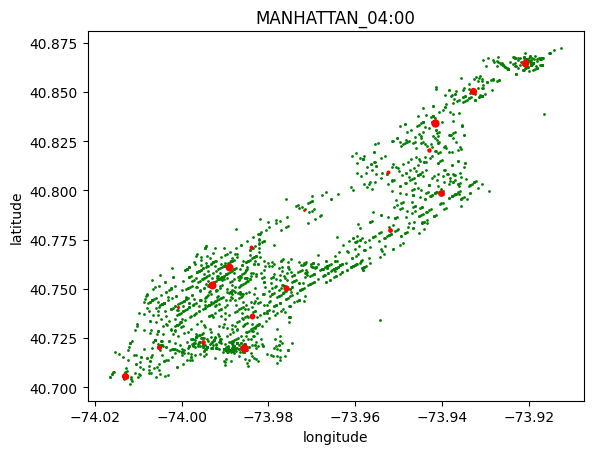

In [23]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.9:
        if i[0]>40.70 and i[0]<40.90:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if j[1]>-74.05 and j[1]<-73.9:
        if j[0]>40.70 and j[0]<40.90:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("MANHATTAN_04:00")

In [24]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.736276285416665, -73.98377576666665, 96],
 [40.8204308402985, -73.94289037462687, 67],
 [40.79022713870968, -73.97190759354838, 31],
 [40.86478108880597, -73.92100775522388, 134],
 [40.771087256603764, -73.98410911320752, 55],
 [40.79872568965517, -73.94012942672413, 116],
 [40.75027220384616, -73.97595667019233, 104],
 [40.71977634161074, -73.98560051812079, 149],
 [40.75185772534247, -73.9929628869863, 143],
 [40.726624, -73.7349, 1],
 [40.76133852014389, -73.96516207194244, 139],
 [40.76090244758065, -73.98903587822583, 126],
 [40.85039953472222, -73.93281111666666, 72],
 [40.722725397580646, -73.99499035564517, 124],
 [40.705503718421056, -74.01297529210525, 38],
 [40.74078039801324, -74.00076650198677, 150],
 [40.834180858928576, -73.94162978214285, 56],
 [40.809434063513514, -73.95239400675675, 74],
 [40.779805008333334, -73.95202797857142, 84],
 [40.720418872527475, -74.00524252417583, 91]]

### 05:00

In [25]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='05:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="MANHATTAN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+---------+--------+--------------------+
| latitude| longitude|  borough|    time|            features|
+---------+----------+---------+--------+--------------------+
|40.765152|-73.995155|MANHATTAN|05:00:00|[40.765152,-73.99...|
|40.757668| -73.99483|MANHATTAN|05:00:00|[40.757668,-73.99...|
| 40.85358|-73.932236|MANHATTAN|05:00:00|[40.85358,-73.932...|
| 40.71987| -73.98371|MANHATTAN|05:00:00|[40.71987,-73.98371]|
|40.723022| -73.99882|MANHATTAN|05:00:00|[40.723022,-73.99...|
| 40.79373|-73.945786|MANHATTAN|05:00:00|[40.79373,-73.945...|
| 40.80549|-73.937965|MANHATTAN|05:00:00|[40.80549,-73.937...|
|40.784615|-73.953964|MANHATTAN|05:00:00|[40.784615,-73.95...|
|40.809246| -73.93598|MANHATTAN|05:00:00|[40.809246,-73.93...|
|40.784878|-73.955894|MANHATTAN|05:00:00|[40.784878,-73.95...|
|40.753998| -73.99775|MANHATTAN|05:00:00|[40.753998,-73.99...|
| 40.76484|-73.970505|MANHATTAN|05:00:00|[40.76484,-73.970...|
|40.720234| -73.98448|MANHATTAN|05:00:00|[40.720234,-73

In [26]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+---------+--------+--------------------+----------+
| latitude| longitude|  borough|    time|            features|prediction|
+---------+----------+---------+--------+--------------------+----------+
|40.765152|-73.995155|MANHATTAN|05:00:00|[40.765152,-73.99...|         9|
|40.757668| -73.99483|MANHATTAN|05:00:00|[40.757668,-73.99...|         4|
| 40.85358|-73.932236|MANHATTAN|05:00:00|[40.85358,-73.932...|         2|
| 40.71987| -73.98371|MANHATTAN|05:00:00|[40.71987,-73.98371]|        18|
|40.723022| -73.99882|MANHATTAN|05:00:00|[40.723022,-73.99...|        10|
| 40.79373|-73.945786|MANHATTAN|05:00:00|[40.79373,-73.945...|         7|
| 40.80549|-73.937965|MANHATTAN|05:00:00|[40.80549,-73.937...|        13|
|40.784615|-73.953964|MANHATTAN|05:00:00|[40.784615,-73.95...|        19|
|40.809246| -73.93598|MANHATTAN|05:00:00|[40.809246,-73.93...|        13|
|40.784878|-73.955894|MANHATTAN|05:00:00|[40.784878,-73.95...|        19|
|40.753998| -73.99775|MANHATTAN|05:00:

Text(0.5, 1.0, 'MANHATTAN_05:00')

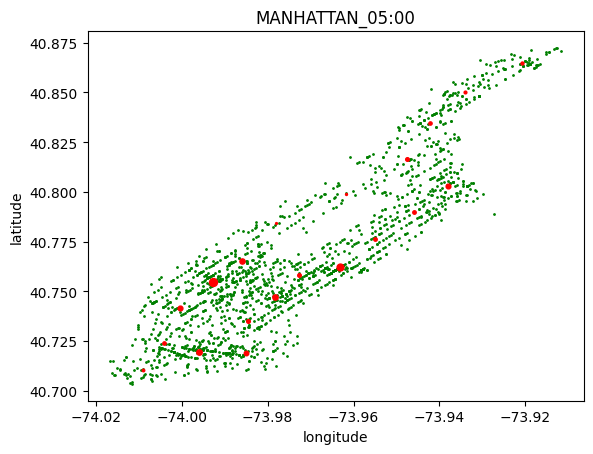

In [27]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.9:
        if i[0]>40.70 and i[0]<40.90:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if j[1]>-74.05 and j[1]<-73.9:
        if j[0]>40.70 and j[0]<40.90:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("MANHATTAN_05:00")

In [28]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.79892318333333, -73.96184288333332, 42],
 [40.74167312788461, -74.00042797884616, 104],
 [40.85004661833334, -73.934050415, 60],
 [40.72414980821918, -74.00424614383562, 73],
 [40.754514008139545, -73.99273657848838, 172],
 [40.86481700461538, -73.9208433353846, 65],
 [40.758405039743586, -73.9726073551282, 78],
 [40.790056828000004, -73.94589391333334, 75],
 [40.81673354050631, -73.94748906202531, 79],
 [40.76546116371682, -73.98606302300884, 113],
 [40.71972538319328, -73.99588411344536, 119],
 [40.74728121551724, -73.97828124051725, 116],
 [40.71019632181818, -74.00905302545455, 55],
 [40.80296939805825, -73.93796084271845, 103],
 [40.73487244177215, -73.98452366582278, 79],
 [40.83479215492957, -73.94217205915493, 71],
 [40.762077991946306, -73.96315867919462, 149],
 [40.784224905, -73.97808510000002, 40],
 [40.719092972448976, -73.98501740714285, 98],
 [40.776301763999996, -73.95503912, 75]]

### 06:00

In [29]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='06:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="MANHATTAN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+---------+--------+--------------------+
| latitude| longitude|  borough|    time|            features|
+---------+----------+---------+--------+--------------------+
|40.734352| -74.00849|MANHATTAN|06:00:00|[40.734352,-74.00...|
|40.758633| -73.96579|MANHATTAN|06:00:00|[40.758633,-73.96...|
| 40.79097|-73.953156|MANHATTAN|06:00:00|[40.79097,-73.953...|
| 40.72224|  -73.9863|MANHATTAN|06:00:00| [40.72224,-73.9863]|
| 40.83027| -73.94393|MANHATTAN|06:00:00|[40.83027,-73.94393]|
|40.737007| -73.98157|MANHATTAN|06:00:00|[40.737007,-73.98...|
|40.775562| -73.95035|MANHATTAN|06:00:00|[40.775562,-73.95...|
| 40.80208|   -73.937|MANHATTAN|06:00:00|  [40.80208,-73.937]|
| 40.75348|-73.980896|MANHATTAN|06:00:00|[40.75348,-73.980...|
|40.841393|-73.936844|MANHATTAN|06:00:00|[40.841393,-73.93...|
| 40.80777| -73.94549|MANHATTAN|06:00:00|[40.80777,-73.94549]|
|40.738552| -73.98043|MANHATTAN|06:00:00|[40.738552,-73.98...|
| 40.75898| -73.96244|MANHATTAN|06:00:00|[40.75898,-73.

In [30]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+---------+--------+--------------------+----------+
| latitude| longitude|  borough|    time|            features|prediction|
+---------+----------+---------+--------+--------------------+----------+
|40.734352| -74.00849|MANHATTAN|06:00:00|[40.734352,-74.00...|        12|
|40.758633| -73.96579|MANHATTAN|06:00:00|[40.758633,-73.96...|         1|
| 40.79097|-73.953156|MANHATTAN|06:00:00|[40.79097,-73.953...|        10|
| 40.72224|  -73.9863|MANHATTAN|06:00:00| [40.72224,-73.9863]|        18|
| 40.83027| -73.94393|MANHATTAN|06:00:00|[40.83027,-73.94393]|        13|
|40.737007| -73.98157|MANHATTAN|06:00:00|[40.737007,-73.98...|         5|
|40.775562| -73.95035|MANHATTAN|06:00:00|[40.775562,-73.95...|        19|
| 40.80208|   -73.937|MANHATTAN|06:00:00|  [40.80208,-73.937]|         0|
| 40.75348|-73.980896|MANHATTAN|06:00:00|[40.75348,-73.980...|        16|
|40.841393|-73.936844|MANHATTAN|06:00:00|[40.841393,-73.93...|         8|
| 40.80777| -73.94549|MANHATTAN|06:00:

Text(0.5, 1.0, 'MANHATTAN_06:00')

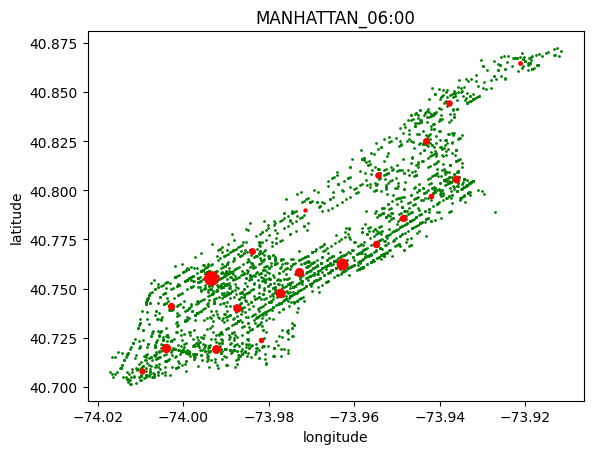

In [31]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.9:
        if i[0]>40.70 and i[0]<40.90:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if j[1]>-74.05 and j[1]<-73.9:
        if j[0]>40.70 and j[0]<40.90:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("MANHATTAN_06:00")

In [32]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.80553544714286, -73.93618930357142, 140],
 [40.76259895155556, -73.96293939777777, 225],
 [40.719890380924845, -74.00405560462427, 173],
 [40.789770968750005, -73.9716108375, 64],
 [40.86453938800001, -73.921272588, 75],
 [40.74010913841061, -73.98749150066223, 152],
 [40.70784953396226, -74.00972881320754, 106],
 [40.71928679079755, -73.992290103681, 163],
 [40.8445667392857, -73.93779430892856, 112],
 [40.76929588319327, -73.98396578907563, 119],
 [40.78583142777778, -73.94853922619048, 126],
 [40.75548732328767, -73.99364617705477, 292],
 [40.741044759055114, -74.00288877795275, 127],
 [40.82509138699187, -73.94316755203253, 123],
 [40.75863188313254, -73.97300096927711, 166],
 [40.80779347105262, -73.9545645114035, 114],
 [40.74788536388889, -73.97746939500001, 180],
 [40.79698433846154, -73.94209258241759, 91],
 [40.72392061318682, -73.9817299956044, 90],
 [40.772746429771, -73.95495344885497, 131]]

### 07:00

In [33]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='07:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="MANHATTAN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+---------+--------+--------------------+
| latitude| longitude|  borough|    time|            features|
+---------+----------+---------+--------+--------------------+
|40.785774| -73.97052|MANHATTAN|07:00:00|[40.785774,-73.97...|
|  40.8188| -73.95603|MANHATTAN|07:00:00| [40.8188,-73.95603]|
| 40.72066|-73.983284|MANHATTAN|07:00:00|[40.72066,-73.983...|
|40.806778|-73.943115|MANHATTAN|07:00:00|[40.806778,-73.94...|
|40.819283|-73.937096|MANHATTAN|07:00:00|[40.819283,-73.93...|
| 40.76542| -73.98383|MANHATTAN|07:00:00|[40.76542,-73.98383]|
|40.730457| -73.99366|MANHATTAN|07:00:00|[40.730457,-73.99...|
|40.706722| -74.00679|MANHATTAN|07:00:00|[40.706722,-74.00...|
| 40.78517|-73.973145|MANHATTAN|07:00:00|[40.78517,-73.973...|
|40.749596|  -73.9873|MANHATTAN|07:00:00|[40.749596,-73.9873]|
| 40.71552| -74.00925|MANHATTAN|07:00:00|[40.71552,-74.00925]|
|40.819454| -73.94069|MANHATTAN|07:00:00|[40.819454,-73.94...|
| 40.76367| -73.98881|MANHATTAN|07:00:00|[40.76367,-73.

In [34]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+---------+--------+--------------------+----------+
| latitude| longitude|  borough|    time|            features|prediction|
+---------+----------+---------+--------+--------------------+----------+
|40.785774| -73.97052|MANHATTAN|07:00:00|[40.785774,-73.97...|         9|
|  40.8188| -73.95603|MANHATTAN|07:00:00| [40.8188,-73.95603]|        17|
| 40.72066|-73.983284|MANHATTAN|07:00:00|[40.72066,-73.983...|        13|
|40.806778|-73.943115|MANHATTAN|07:00:00|[40.806778,-73.94...|        10|
|40.819283|-73.937096|MANHATTAN|07:00:00|[40.819283,-73.93...|         1|
| 40.76542| -73.98383|MANHATTAN|07:00:00|[40.76542,-73.98383]|         7|
|40.730457| -73.99366|MANHATTAN|07:00:00|[40.730457,-73.99...|         4|
|40.706722| -74.00679|MANHATTAN|07:00:00|[40.706722,-74.00...|         8|
| 40.78517|-73.973145|MANHATTAN|07:00:00|[40.78517,-73.973...|         9|
|40.749596|  -73.9873|MANHATTAN|07:00:00|[40.749596,-73.9873]|        12|
| 40.71552| -74.00925|MANHATTAN|07:00:

Text(0.5, 1.0, 'MANHATTAN_07:00')

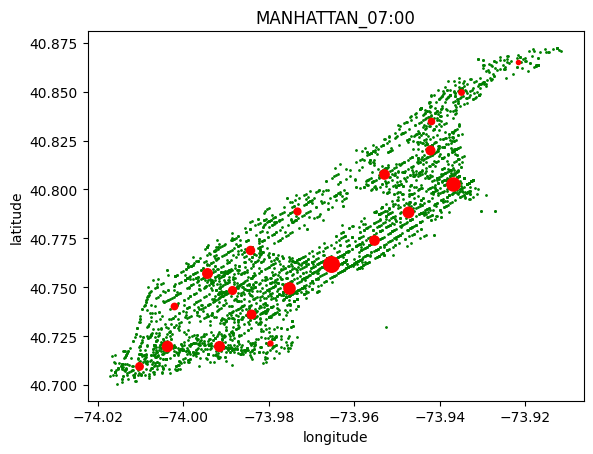

In [35]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.9:
        if i[0]>40.70 and i[0]<40.90:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if j[1]>-74.05 and j[1]<-73.9:
        if j[0]>40.70 and j[0]<40.90:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("MANHATTAN_07:00")

In [36]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.73604363189189, -73.98420865405404, 185],
 [40.82015382096775, -73.94228597043012, 186],
 [40.761894780357146, -73.96556318124998, 336],
 [40.86540710222222, -73.92182149555555, 90],
 [40.7200199360577, -73.99170626490385, 209],
 [40.74953082479339, -73.97534711280993, 242],
 [40.84982718474576, -73.93498902711865, 118],
 [40.76922933314285, -73.98437796285715, 175],
 [40.70963258765431, -74.01039576790124, 161],
 [40.78881218299319, -73.97345476394557, 147],
 [40.80257806971831, -73.93705178028168, 284],
 [40.720093083636364, -74.00372205545455, 219],
 [40.74858421017964, -73.9885511215569, 167],
 [40.721450195192304, -73.97977246153846, 105],
 [40.788234659471364, -73.94737594008814, 227],
 [40.740538326086956, -74.00213764565218, 138],
 [40.83513890970149, -73.94206058358208, 134],
 [40.80776515771144, -73.95313951243782, 201],
 [40.75736450194175, -73.994384084466, 206],
 [40.7739722800995, -73.95550187761195, 201]]

### 08:00

In [37]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='08:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="MANHATTAN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+---------+--------+--------------------+
| latitude| longitude|  borough|    time|            features|
+---------+----------+---------+--------+--------------------+
|40.833786| -73.94037|MANHATTAN|08:00:00|[40.833786,-73.94...|
| 40.82207| -73.94993|MANHATTAN|08:00:00|[40.82207,-73.94993]|
|40.708324| -74.00311|MANHATTAN|08:00:00|[40.708324,-74.00...|
|40.748825| -73.96984|MANHATTAN|08:00:00|[40.748825,-73.96...|
| 40.76161| -73.97076|MANHATTAN|08:00:00|[40.76161,-73.97076]|
|40.761234| -73.96389|MANHATTAN|08:00:00|[40.761234,-73.96...|
| 40.80765|-73.939255|MANHATTAN|08:00:00|[40.80765,-73.939...|
|  40.7982|-73.961815|MANHATTAN|08:00:00|[40.7982,-73.961815]|
| 40.77291|-73.962524|MANHATTAN|08:00:00|[40.77291,-73.962...|
| 40.84812| -73.92971|MANHATTAN|08:00:00|[40.84812,-73.92971]|
|40.709206| -73.99607|MANHATTAN|08:00:00|[40.709206,-73.99...|
| 40.80142| -73.93446|MANHATTAN|08:00:00|[40.80142,-73.93446]|
|40.791084|-73.953445|MANHATTAN|08:00:00|[40.791084,-73

In [38]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+---------+--------+--------------------+----------+
| latitude| longitude|  borough|    time|            features|prediction|
+---------+----------+---------+--------+--------------------+----------+
|40.833786| -73.94037|MANHATTAN|08:00:00|[40.833786,-73.94...|        19|
| 40.82207| -73.94993|MANHATTAN|08:00:00|[40.82207,-73.94993]|        19|
|40.708324| -74.00311|MANHATTAN|08:00:00|[40.708324,-74.00...|        10|
|40.748825| -73.96984|MANHATTAN|08:00:00|[40.748825,-73.96...|         5|
| 40.76161| -73.97076|MANHATTAN|08:00:00|[40.76161,-73.97076]|         8|
|40.761234| -73.96389|MANHATTAN|08:00:00|[40.761234,-73.96...|         8|
| 40.80765|-73.939255|MANHATTAN|08:00:00|[40.80765,-73.939...|         4|
|  40.7982|-73.961815|MANHATTAN|08:00:00|[40.7982,-73.961815]|         2|
| 40.77291|-73.962524|MANHATTAN|08:00:00|[40.77291,-73.962...|         9|
| 40.84812| -73.92971|MANHATTAN|08:00:00|[40.84812,-73.92971]|         3|
|40.709206| -73.99607|MANHATTAN|08:00:

Text(0.5, 1.0, 'MANHATTAN_08:00')

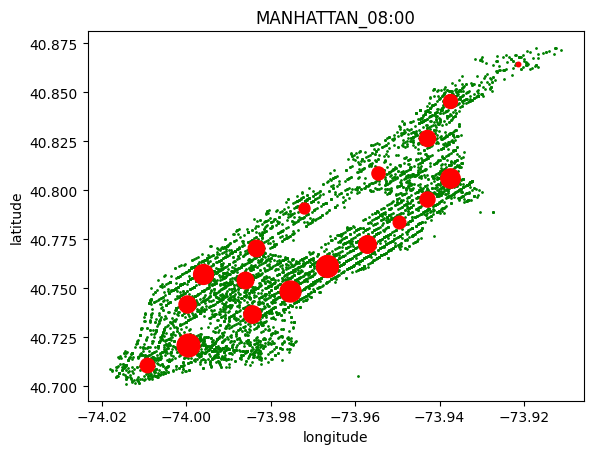

In [39]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.9:
        if i[0]>40.70 and i[0]<40.90:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if j[1]>-74.05 and j[1]<-73.9:
        if j[0]>40.70 and j[0]<40.90:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("MANHATTAN_08:00")

In [40]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.754172284357544, -73.98606317765363, 358],
 [40.72119675600815, -73.99953030366598, 491],
 [40.79087242941177, -73.97208680168066, 237],
 [40.845271923509934, -73.9374884218543, 302],
 [40.806407924940046, -73.9374128232614, 418],
 [40.74873279514349, -73.97534886423841, 453],
 [40.742023591032606, -73.99993423288043, 368],
 [40.86449122346938, -73.92138582653061, 98],
 [40.76121774566597, -73.96670933446089, 473],
 [40.772591743421046, -73.95709346921052, 380],
 [40.71091369265175, -74.00933751405749, 313],
 [40.73670534069149, -73.98432350319149, 376],
 [40.77037581652661, -73.98346037563024, 357],
 [40.79578604754602, -73.94288946993865, 326],
 [40.80885184366196, -73.95461952957747, 285],
 [40.783834171062274, -73.94969675018315, 273],
 [40.75753736939252, -73.99603147546728, 428],
 [40.681169499999996, -73.799935, 2],
 [40.71914672183908, -73.98552668247127, 348],
 [40.826859399358966, -73.94302018717948, 311]]

### 09:00

In [41]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='09:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="MANHATTAN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+---------+--------+--------------------+
| latitude| longitude|  borough|    time|            features|
+---------+----------+---------+--------+--------------------+
| 40.71649| -73.98484|MANHATTAN|09:00:00|[40.71649,-73.98484]|
|40.788673| -73.97136|MANHATTAN|09:00:00|[40.788673,-73.97...|
| 40.79157| -73.94469|MANHATTAN|09:00:00|[40.79157,-73.94469]|
| 40.75545|-73.962105|MANHATTAN|09:00:00|[40.75545,-73.962...|
|  40.7802| -73.98755|MANHATTAN|09:00:00| [40.7802,-73.98755]|
| 40.82831| -73.94315|MANHATTAN|09:00:00|[40.82831,-73.94315]|
|40.713444| -73.99854|MANHATTAN|09:00:00|[40.713444,-73.99...|
| 40.76578| -73.96495|MANHATTAN|09:00:00|[40.76578,-73.96495]|
| 40.80574|-73.942764|MANHATTAN|09:00:00|[40.80574,-73.942...|
| 40.74768| -73.97498|MANHATTAN|09:00:00|[40.74768,-73.97498]|
|40.800617|  -73.9465|MANHATTAN|09:00:00|[40.800617,-73.9465]|
| 40.74854| -73.97315|MANHATTAN|09:00:00|[40.74854,-73.97315]|
|40.795956| -73.94522|MANHATTAN|09:00:00|[40.795956,-73

In [42]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+---------+--------+--------------------+----------+
| latitude| longitude|  borough|    time|            features|prediction|
+---------+----------+---------+--------+--------------------+----------+
| 40.71649| -73.98484|MANHATTAN|09:00:00|[40.71649,-73.98484]|        16|
|40.788673| -73.97136|MANHATTAN|09:00:00|[40.788673,-73.97...|         2|
| 40.79157| -73.94469|MANHATTAN|09:00:00|[40.79157,-73.94469]|        19|
| 40.75545|-73.962105|MANHATTAN|09:00:00|[40.75545,-73.962...|        14|
|  40.7802| -73.98755|MANHATTAN|09:00:00| [40.7802,-73.98755]|         2|
| 40.82831| -73.94315|MANHATTAN|09:00:00|[40.82831,-73.94315]|         6|
|40.713444| -73.99854|MANHATTAN|09:00:00|[40.713444,-73.99...|         4|
| 40.76578| -73.96495|MANHATTAN|09:00:00|[40.76578,-73.96495]|        14|
| 40.80574|-73.942764|MANHATTAN|09:00:00|[40.80574,-73.942...|         1|
| 40.74768| -73.97498|MANHATTAN|09:00:00|[40.74768,-73.97498]|        17|
|40.800617|  -73.9465|MANHATTAN|09:00:

Text(0.5, 1.0, 'MANHATTAN_09:00')

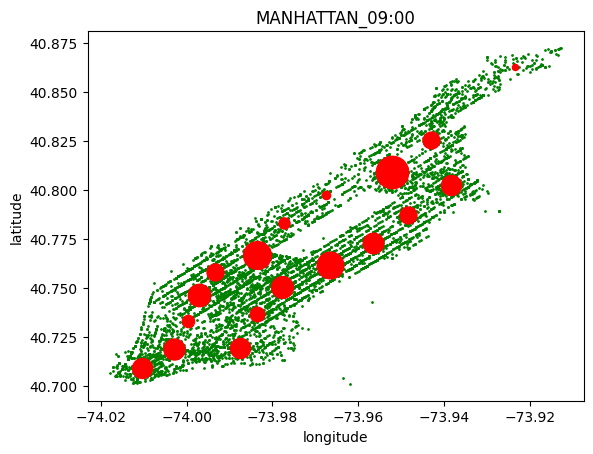

In [43]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.9:
        if i[0]>40.70 and i[0]<40.90:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if j[1]>-74.05 and j[1]<-73.9:
        if j[0]>40.70 and j[0]<40.90:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("MANHATTAN_09:00")

In [44]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.74637790977132, -73.99722731850312, 484],
 [40.802440124825985, -73.93829448816706, 431],
 [40.78313425082645, -73.97738284917355, 241],
 [40.77283010810811, -73.95658030608108, 444],
 [40.71851888876652, -74.00302175506607, 454],
 [40.86256291374046, -73.92352721603054, 131],
 [40.82529117802198, -73.94301733516484, 365],
 [40.732985531578954, -73.999753812406, 264],
 [40.79721427897728, -73.96759767727274, 178],
 [40.674053, -73.73022, 1],
 [40.84458326265823, -73.93843589430381, 314],
 [40.73645990462962, -73.9836286523148, 431],
 [40.70898026893733, -74.01051256321526, 367],
 [40.757929708462875, -73.99352429136442, 576],
 [40.76141392229618, -73.96646504326125, 600],
 [40.7667110701878, -73.98368197840374, 434],
 [40.71942793085107, -73.98769358638297, 470],
 [40.75006463735795, -73.97767675923296, 699],
 [40.80888139289617, -73.95215830245901, 367],
 [40.786823209477134, -73.94830193333334, 306]]

### 10:00

In [45]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='10:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="MANHATTAN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+---------+--------+--------------------+
| latitude| longitude|  borough|    time|            features|
+---------+----------+---------+--------+--------------------+
|40.778805|-73.974075|MANHATTAN|10:00:00|[40.778805,-73.97...|
|40.781315| -73.94614|MANHATTAN|10:00:00|[40.781315,-73.94...|
|40.779602| -73.95553|MANHATTAN|10:00:00|[40.779602,-73.95...|
| 40.74608|-73.974945|MANHATTAN|10:00:00|[40.74608,-73.974...|
|40.803787|-73.953896|MANHATTAN|10:00:00|[40.803787,-73.95...|
|40.766586|  -73.9531|MANHATTAN|10:00:00|[40.766586,-73.9531]|
| 40.75734| -73.98602|MANHATTAN|10:00:00|[40.75734,-73.98602]|
|40.798584| -73.93353|MANHATTAN|10:00:00|[40.798584,-73.93...|
|40.763477| -73.96144|MANHATTAN|10:00:00|[40.763477,-73.96...|
| 40.77632| -73.96002|MANHATTAN|10:00:00|[40.77632,-73.96002]|
|40.764626| -73.99555|MANHATTAN|10:00:00|[40.764626,-73.99...|
|40.800507|-73.938156|MANHATTAN|10:00:00|[40.800507,-73.93...|
|40.793633| -73.94165|MANHATTAN|10:00:00|[40.793633,-73

In [46]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+---------+--------+--------------------+----------+
| latitude| longitude|  borough|    time|            features|prediction|
+---------+----------+---------+--------+--------------------+----------+
|40.778805|-73.974075|MANHATTAN|10:00:00|[40.778805,-73.97...|        17|
|40.781315| -73.94614|MANHATTAN|10:00:00|[40.781315,-73.94...|         8|
|40.779602| -73.95553|MANHATTAN|10:00:00|[40.779602,-73.95...|        15|
| 40.74608|-73.974945|MANHATTAN|10:00:00|[40.74608,-73.974...|         2|
|40.803787|-73.953896|MANHATTAN|10:00:00|[40.803787,-73.95...|         6|
|40.766586|  -73.9531|MANHATTAN|10:00:00|[40.766586,-73.9531]|        15|
| 40.75734| -73.98602|MANHATTAN|10:00:00|[40.75734,-73.98602]|        13|
|40.798584| -73.93353|MANHATTAN|10:00:00|[40.798584,-73.93...|         1|
|40.763477| -73.96144|MANHATTAN|10:00:00|[40.763477,-73.96...|         5|
| 40.77632| -73.96002|MANHATTAN|10:00:00|[40.77632,-73.96002]|        15|
|40.764626| -73.99555|MANHATTAN|10:00:

Text(0.5, 1.0, 'MANHATTAN_10:00')

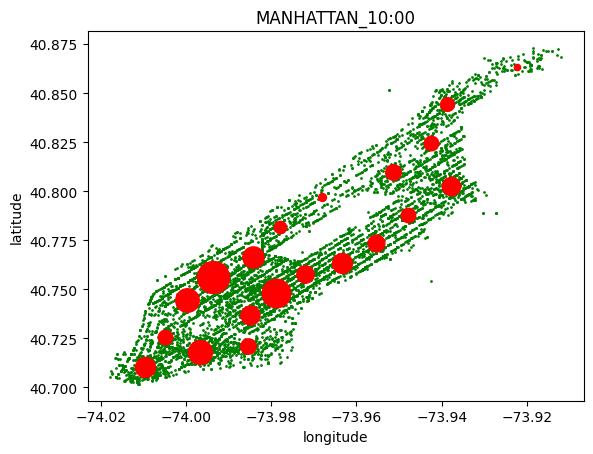

In [47]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.9:
        if i[0]>40.70 and i[0]<40.90:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if j[1]>-74.05 and j[1]<-73.9:
        if j[0]>40.70 and j[0]<40.90:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("MANHATTAN_10:00")

In [48]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.721350062499994, -73.98538053837208, 334],
 [40.80260033443038, -73.93776875088606, 395],
 [40.74828383987034, -73.97878901215557, 616],
 [40.710156690000005, -74.00956172906977, 431],
 [40.8445634580537, -73.93870598389262, 298],
 [40.76362634672898, -73.96329159415887, 430],
 [40.80972068630952, -73.95135597708332, 336],
 [40.725922923322685, -74.0048187396166, 313],
 [40.78795167179487, -73.94779411923075, 312],
 [40.74441418703339, -73.99970735481335, 509],
 [40.86325873481482, -73.92236104296298, 135],
 [40.73699787279411, -73.98488076617646, 410],
 [40.796955830409345, -73.96809854619883, 171],
 [40.75617298606677, -73.99360323265603, 689],
 [40.76634193499999, -73.98424087434783, 460],
 [40.77373358429751, -73.95543598953168, 363],
 [40.824446862738846, -73.94251596974524, 314],
 [40.78186750981133, -73.97792214415094, 265],
 [40.71826966536204, -73.99660981682975, 518],
 [40.75764037393617, -73.97199687473403, 375]]

### 11:00

In [49]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='11:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="MANHATTAN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+---------+--------+--------------------+
| latitude| longitude|  borough|    time|            features|
+---------+----------+---------+--------+--------------------+
| 40.71975|-73.992165|MANHATTAN|11:00:00|[40.71975,-73.992...|
|40.770065|-73.949394|MANHATTAN|11:00:00|[40.770065,-73.94...|
|40.837803| -73.94215|MANHATTAN|11:00:00|[40.837803,-73.94...|
|40.813385| -73.94511|MANHATTAN|11:00:00|[40.813385,-73.94...|
|40.771946|-73.952995|MANHATTAN|11:00:00|[40.771946,-73.95...|
| 40.75591| -73.99448|MANHATTAN|11:00:00|[40.75591,-73.99448]|
|40.743332| -73.99991|MANHATTAN|11:00:00|[40.743332,-73.99...|
| 40.78257| -73.94522|MANHATTAN|11:00:00|[40.78257,-73.94522]|
| 40.76814| -73.98622|MANHATTAN|11:00:00|[40.76814,-73.98622]|
|40.752598| -73.96702|MANHATTAN|11:00:00|[40.752598,-73.96...|
|40.848682|-73.939224|MANHATTAN|11:00:00|[40.848682,-73.93...|
| 40.82803|-73.934845|MANHATTAN|11:00:00|[40.82803,-73.934...|
| 40.72071| -73.99582|MANHATTAN|11:00:00|[40.72071,-73.

In [50]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+---------+--------+--------------------+----------+
| latitude| longitude|  borough|    time|            features|prediction|
+---------+----------+---------+--------+--------------------+----------+
| 40.71975|-73.992165|MANHATTAN|11:00:00|[40.71975,-73.992...|         3|
|40.770065|-73.949394|MANHATTAN|11:00:00|[40.770065,-73.94...|        14|
|40.837803| -73.94215|MANHATTAN|11:00:00|[40.837803,-73.94...|        17|
|40.813385| -73.94511|MANHATTAN|11:00:00|[40.813385,-73.94...|         9|
|40.771946|-73.952995|MANHATTAN|11:00:00|[40.771946,-73.95...|        14|
| 40.75591| -73.99448|MANHATTAN|11:00:00|[40.75591,-73.99448]|        12|
|40.743332| -73.99991|MANHATTAN|11:00:00|[40.743332,-73.99...|        15|
| 40.78257| -73.94522|MANHATTAN|11:00:00|[40.78257,-73.94522]|         2|
| 40.76814| -73.98622|MANHATTAN|11:00:00|[40.76814,-73.98622]|         6|
|40.752598| -73.96702|MANHATTAN|11:00:00|[40.752598,-73.96...|         5|
|40.848682|-73.939224|MANHATTAN|11:00:

Text(0.5, 1.0, 'MANHATTAN_11:00')

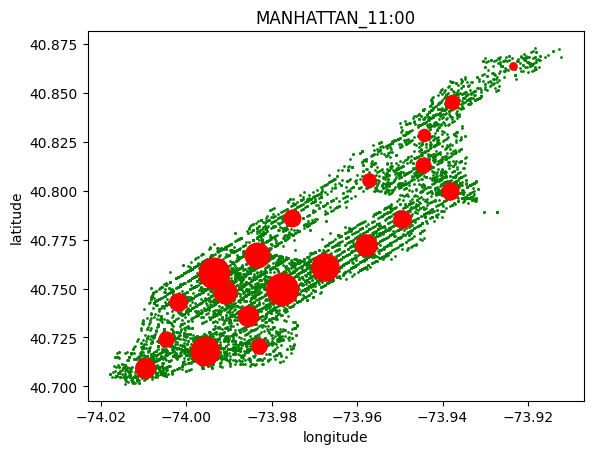

In [51]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.9:
        if i[0]>40.70 and i[0]<40.90:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if j[1]>-74.05 and j[1]<-73.9:
        if j[0]>40.70 and j[0]<40.90:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("MANHATTAN_11:00")

In [52]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.7999921705722, -73.93826930653951, 366],
 [40.74803229857144, -73.99107822346939, 491],
 [40.78552941313673, -73.9494841680965, 374],
 [40.71827161699347, -73.99555594215687, 612],
 [40.86351406521738, -73.9235542236025, 159],
 [40.760785649233384, -73.96756119301533, 586],
 [40.767277151789074, -73.98335665273068, 531],
 [40.73617779354838, -73.98550932926267, 433],
 [40.82863936603775, -73.94440756339623, 263],
 [40.81302495094341, -73.94460646603773, 319],
 [40.749945229489036, -73.97759233357664, 682],
 [40.70922638554502, -74.00966472867299, 422],
 [40.75808604938838, -73.99347558929665, 661],
 [40.805306943661975, -73.95732593556338, 287],
 [40.77221026244541, -73.95786035655021, 458],
 [40.74303387097626, -74.00188832612137, 377],
 [40.724065948297216, -74.00475401795666, 323],
 [40.84527307218543, -73.9378678165563, 302],
 [40.720424254103335, -73.98295673708206, 328],
 [40.786026577437326, -73.97536179665737, 359]]

### 12:00

In [53]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='12:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="MANHATTAN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+------------------+----------+---------+--------+--------------------+
|          latitude| longitude|  borough|    time|            features|
+------------------+----------+---------+--------+--------------------+
|         40.736614|  -73.9951|MANHATTAN|12:00:00|[40.736614,-73.9951]|
|          40.75632|-73.999275|MANHATTAN|12:00:00|[40.75632,-73.999...|
|         40.746395|  -73.9856|MANHATTAN|12:00:00|[40.746395,-73.9856]|
|         40.724846|   -73.999|MANHATTAN|12:00:00| [40.724846,-73.999]|
|          40.80609| -73.95414|MANHATTAN|12:00:00|[40.80609,-73.95414]|
|         40.751446|-74.001434|MANHATTAN|12:00:00|[40.751446,-74.00...|
|40.778605999999996| -73.98163|MANHATTAN|12:00:00|[40.7786059999999...|
|         40.762234| -73.98987|MANHATTAN|12:00:00|[40.762234,-73.98...|
|          40.74708| -73.98135|MANHATTAN|12:00:00|[40.74708,-73.98135]|
|         40.824734| -73.94854|MANHATTAN|12:00:00|[40.824734,-73.94...|
|         40.706142| -74.00603|MANHATTAN|12:00:00|[40.706142,-74

In [54]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+------------------+----------+---------+--------+--------------------+----------+
|          latitude| longitude|  borough|    time|            features|prediction|
+------------------+----------+---------+--------+--------------------+----------+
|         40.736614|  -73.9951|MANHATTAN|12:00:00|[40.736614,-73.9951]|         4|
|          40.75632|-73.999275|MANHATTAN|12:00:00|[40.75632,-73.999...|         2|
|         40.746395|  -73.9856|MANHATTAN|12:00:00|[40.746395,-73.9856]|         3|
|         40.724846|   -73.999|MANHATTAN|12:00:00| [40.724846,-73.999]|         6|
|          40.80609| -73.95414|MANHATTAN|12:00:00|[40.80609,-73.95414]|         9|
|         40.751446|-74.001434|MANHATTAN|12:00:00|[40.751446,-74.00...|        14|
|40.778605999999996| -73.98163|MANHATTAN|12:00:00|[40.7786059999999...|         5|
|         40.762234| -73.98987|MANHATTAN|12:00:00|[40.762234,-73.98...|        11|
|          40.74708| -73.98135|MANHATTAN|12:00:00|[40.74708,-73.98135]|         3|
|   

Text(0.5, 1.0, 'MANHATTAN_12:00')

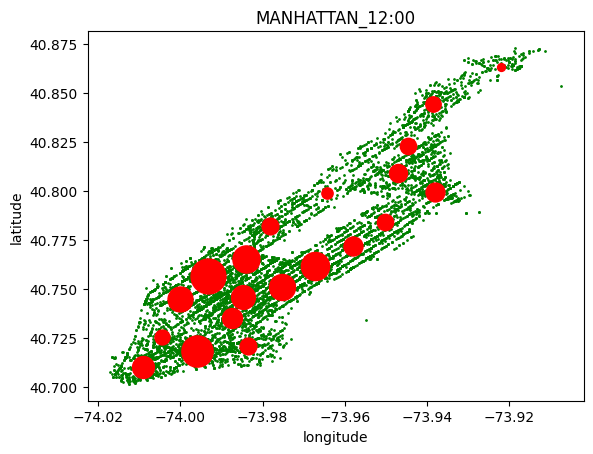

In [55]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.9:
        if i[0]>40.70 and i[0]<40.90:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if j[1]>-74.05 and j[1]<-73.9:
        if j[0]>40.70 and j[0]<40.90:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("MANHATTAN_12:00")

In [56]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.71836744340741, -73.99604439214815, 675],
 [40.823164200835656, -73.9446311994429, 353],
 [40.75640516074271, -73.99333232148541, 754],
 [40.746079368932044, -73.98466975902913, 514],
 [40.73498756392693, -73.98742403858445, 432],
 [40.78222034393532, -73.97808876981134, 363],
 [40.725508281424155, -74.00448050743036, 323],
 [40.79923974572864, -73.93797046984925, 409],
 [40.784027309383376, -73.9502997919571, 353],
 [40.80924828025642, -73.94698122461539, 390],
 [40.86339820764706, -73.92205396529411, 170],
 [40.76504358444444, -73.98411668051281, 587],
 [40.799146317004045, -73.9644159562753, 244],
 [40.75104166666666, -73.97522543822463, 562],
 [40.744659821851855, -74.00018984907408, 539],
 [40.76160456705882, -73.96735128319327, 609],
 [40.84420654670659, -73.9385498997006, 333],
 [40.77183872388059, -73.9580158340796, 411],
 [40.72106048677686, -73.98361911680442, 363],
 [40.7102532371308, -74.00904490232068, 474]]

### 13:00

In [57]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='13:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="MANHATTAN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+---------+--------+--------------------+
| latitude| longitude|  borough|    time|            features|
+---------+----------+---------+--------+--------------------+
|40.730446| -74.00431|MANHATTAN|13:00:00|[40.730446,-74.00...|
|40.802982| -73.93815|MANHATTAN|13:00:00|[40.802982,-73.93...|
|  40.7963| -73.93829|MANHATTAN|13:00:00| [40.7963,-73.93829]|
| 40.78847|-73.968895|MANHATTAN|13:00:00|[40.78847,-73.968...|
|40.797405|-73.942535|MANHATTAN|13:00:00|[40.797405,-73.94...|
|40.764896| -73.97256|MANHATTAN|13:00:00|[40.764896,-73.97...|
|40.750988| -73.99063|MANHATTAN|13:00:00|[40.750988,-73.99...|
| 40.83978| -73.94322|MANHATTAN|13:00:00|[40.83978,-73.94322]|
| 40.73555|-73.979355|MANHATTAN|13:00:00|[40.73555,-73.979...|
|40.747044| -73.98713|MANHATTAN|13:00:00|[40.747044,-73.98...|
|40.764652| -73.97798|MANHATTAN|13:00:00|[40.764652,-73.97...|
| 40.72261| -73.99242|MANHATTAN|13:00:00|[40.72261,-73.99242]|
|40.808407| -73.95248|MANHATTAN|13:00:00|[40.808407,-73

In [58]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+---------+--------+--------------------+----------+
| latitude| longitude|  borough|    time|            features|prediction|
+---------+----------+---------+--------+--------------------+----------+
|40.730446| -74.00431|MANHATTAN|13:00:00|[40.730446,-74.00...|         7|
|40.802982| -73.93815|MANHATTAN|13:00:00|[40.802982,-73.93...|        15|
|  40.7963| -73.93829|MANHATTAN|13:00:00| [40.7963,-73.93829]|        15|
| 40.78847|-73.968895|MANHATTAN|13:00:00|[40.78847,-73.968...|        10|
|40.797405|-73.942535|MANHATTAN|13:00:00|[40.797405,-73.94...|        15|
|40.764896| -73.97256|MANHATTAN|13:00:00|[40.764896,-73.97...|        19|
|40.750988| -73.99063|MANHATTAN|13:00:00|[40.750988,-73.99...|         2|
| 40.83978| -73.94322|MANHATTAN|13:00:00|[40.83978,-73.94322]|         6|
| 40.73555|-73.979355|MANHATTAN|13:00:00|[40.73555,-73.979...|         4|
|40.747044| -73.98713|MANHATTAN|13:00:00|[40.747044,-73.98...|         9|
|40.764652| -73.97798|MANHATTAN|13:00:

Text(0.5, 1.0, 'MANHATTAN_13:00')

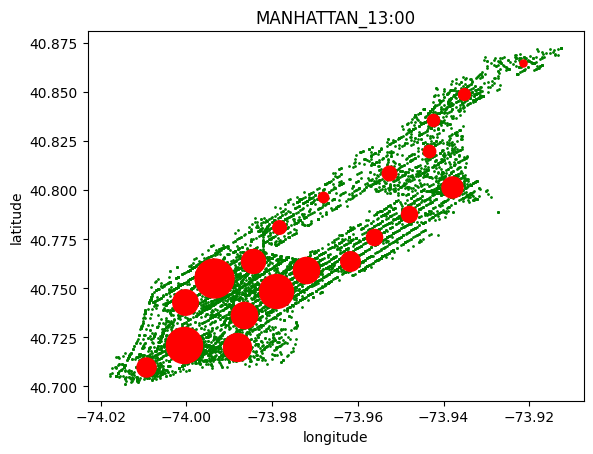

In [59]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.9:
        if i[0]>40.70 and i[0]<40.90:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if j[1]>-74.05 and j[1]<-73.9:
        if j[0]>40.70 and j[0]<40.90:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("MANHATTAN_13:00")

In [60]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.710089574698785, -74.00935729614457, 413],
 [40.8646902248366, -73.92138070784314, 153],
 [40.75520338145064, -73.99364816456598, 841],
 [40.78793885114942, -73.94810578390805, 348],
 [40.73656602733564, -73.986471716436, 567],
 [40.81970666777778, -73.94329430555557, 270],
 [40.83544370152671, -73.94257024274808, 262],
 [40.721018765707136, -74.00060714367962, 780],
 [40.764092864015154, -73.98456296875, 517],
 [40.74842980590659, -73.97918378379123, 734],
 [40.79639296844444, -73.9680852, 225],
 [40.781155230821916, -73.97841361506849, 293],
 [40.80845825301587, -73.9526443584127, 315],
 [40.72000629486301, -73.98810868304794, 603],
 [40.763866005660375, -73.96183975495282, 423],
 [40.80146342346491, -73.93804246557016, 456],
 [40.776188840285705, -73.95614714085715, 350],
 [40.74290576709558, -74.00026529136031, 550],
 [40.84868594335938, -73.93524295976562, 256],
 [40.759254623063065, -73.97200985171172, 567]]

### 14:00

In [61]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='14:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="MANHATTAN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+------------------+----------+---------+--------+--------------------+
|          latitude| longitude|  borough|    time|            features|
+------------------+----------+---------+--------+--------------------+
|          40.75144| -73.97397|MANHATTAN|14:00:00|[40.75144,-73.97397]|
|         40.748158| -73.97033|MANHATTAN|14:00:00|[40.748158,-73.97...|
|         40.747894|-73.989174|MANHATTAN|14:00:00|[40.747894,-73.98...|
|         40.799484| -73.92929|MANHATTAN|14:00:00|[40.799484,-73.92...|
|           40.8188|-73.956024|MANHATTAN|14:00:00|[40.8188,-73.956024]|
|         40.800262| -73.94554|MANHATTAN|14:00:00|[40.800262,-73.94...|
|         40.777504|-73.954956|MANHATTAN|14:00:00|[40.777504,-73.95...|
|           40.7514|-73.983765|MANHATTAN|14:00:00|[40.7514,-73.983765]|
|          40.81084| -73.95068|MANHATTAN|14:00:00|[40.81084,-73.95068]|
|          40.76229|-73.986115|MANHATTAN|14:00:00|[40.76229,-73.986...|
|          40.82403| -73.94476|MANHATTAN|14:00:00|[40.82403,-73.

In [62]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+------------------+----------+---------+--------+--------------------+----------+
|          latitude| longitude|  borough|    time|            features|prediction|
+------------------+----------+---------+--------+--------------------+----------+
|          40.75144| -73.97397|MANHATTAN|14:00:00|[40.75144,-73.97397]|         6|
|         40.748158| -73.97033|MANHATTAN|14:00:00|[40.748158,-73.97...|         6|
|         40.747894|-73.989174|MANHATTAN|14:00:00|[40.747894,-73.98...|         1|
|         40.799484| -73.92929|MANHATTAN|14:00:00|[40.799484,-73.92...|         0|
|           40.8188|-73.956024|MANHATTAN|14:00:00|[40.8188,-73.956024]|        17|
|         40.800262| -73.94554|MANHATTAN|14:00:00|[40.800262,-73.94...|         0|
|         40.777504|-73.954956|MANHATTAN|14:00:00|[40.777504,-73.95...|        14|
|           40.7514|-73.983765|MANHATTAN|14:00:00|[40.7514,-73.983765]|         1|
|          40.81084| -73.95068|MANHATTAN|14:00:00|[40.81084,-73.95068]|        17|
|   

Text(0.5, 1.0, 'MANHATTAN_14:00')

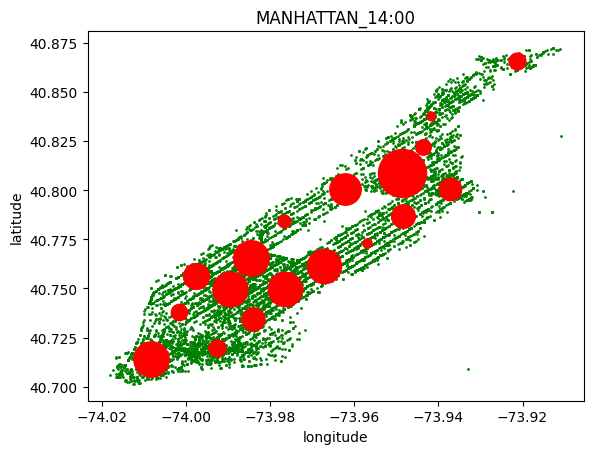

In [63]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.9:
        if i[0]>40.70 and i[0]<40.90:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if j[1]>-74.05 and j[1]<-73.9:
        if j[0]>40.70 and j[0]<40.90:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("MANHATTAN_14:00")

In [64]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.80079656392405, -73.93734279725736, 484],
 [40.74978060718085, -73.98962551090425, 752],
 [40.71404206049869, -74.00819071377954, 762],
 [40.76554049908735, -73.98448728970013, 765],
 [40.821784189393945, -73.94358376818182, 334],
 [40.76159165596206, -73.96718340243902, 738],
 [40.74981098502024, -73.97644702051282, 741],
 [40.669167, -73.851036, 1],
 [40.84947668088235, -73.93476625110294, 273],
 [40.78438438038674, -73.97664158038674, 353],
 [40.73797099738955, -74.0016357437751, 498],
 [40.73441799103943, -73.98404952992831, 558],
 [40.75635125339233, -73.99761791563422, 678],
 [40.800670817889916, -73.9621983211009, 202],
 [40.773229004509794, -73.95687749274511, 510],
 [40.78697928901099, -73.94851011703297, 363],
 [40.719558935356446, -73.99257434922929, 1038],
 [40.80849106742856, -73.94854487428572, 364],
 [40.86541172380952, -73.92142796719575, 188],
 [40.83749416752768, -73.9417366509225, 271]]

### 15:00

In [65]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='15:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="MANHATTAN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+---------+--------+--------------------+
| latitude| longitude|  borough|    time|            features|
+---------+----------+---------+--------+--------------------+
|40.767242|-73.986206|MANHATTAN|15:00:00|[40.767242,-73.98...|
|40.797924|  -73.9296|MANHATTAN|15:00:00|[40.797924,-73.9296]|
|40.806713| -73.93782|MANHATTAN|15:00:00|[40.806713,-73.93...|
|40.724274| -74.01136|MANHATTAN|15:00:00|[40.724274,-74.01...|
| 40.82324|-73.938835|MANHATTAN|15:00:00|[40.82324,-73.938...|
|40.793396| -73.94043|MANHATTAN|15:00:00|[40.793396,-73.94...|
|40.754044|-73.990074|MANHATTAN|15:00:00|[40.754044,-73.99...|
| 40.74058|-73.978935|MANHATTAN|15:00:00|[40.74058,-73.978...|
|  40.8651| -73.92189|MANHATTAN|15:00:00| [40.8651,-73.92189]|
|40.762234| -73.98987|MANHATTAN|15:00:00|[40.762234,-73.98...|
| 40.75217| -73.97778|MANHATTAN|15:00:00|[40.75217,-73.97778]|
|40.798836| -73.93936|MANHATTAN|15:00:00|[40.798836,-73.93...|
|  40.8651| -73.92189|MANHATTAN|15:00:00| [40.8651,-73.

In [66]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+---------+--------+--------------------+----------+
| latitude| longitude|  borough|    time|            features|prediction|
+---------+----------+---------+--------+--------------------+----------+
|40.767242|-73.986206|MANHATTAN|15:00:00|[40.767242,-73.98...|         2|
|40.797924|  -73.9296|MANHATTAN|15:00:00|[40.797924,-73.9296]|        11|
|40.806713| -73.93782|MANHATTAN|15:00:00|[40.806713,-73.93...|        11|
|40.724274| -74.01136|MANHATTAN|15:00:00|[40.724274,-74.01...|        19|
| 40.82324|-73.938835|MANHATTAN|15:00:00|[40.82324,-73.938...|        16|
|40.793396| -73.94043|MANHATTAN|15:00:00|[40.793396,-73.94...|        11|
|40.754044|-73.990074|MANHATTAN|15:00:00|[40.754044,-73.99...|        15|
| 40.74058|-73.978935|MANHATTAN|15:00:00|[40.74058,-73.978...|        13|
|  40.8651| -73.92189|MANHATTAN|15:00:00| [40.8651,-73.92189]|         1|
|40.762234| -73.98987|MANHATTAN|15:00:00|[40.762234,-73.98...|         2|
| 40.75217| -73.97778|MANHATTAN|15:00:

Text(0.5, 1.0, 'MANHATTAN_15:00')

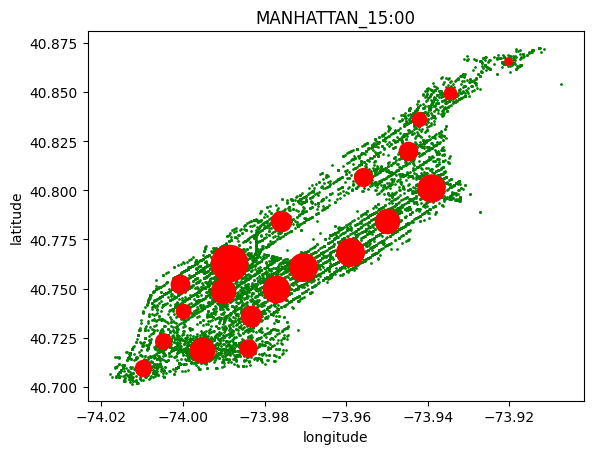

In [67]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.9:
        if i[0]>40.70 and i[0]<40.90:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if j[1]>-74.05 and j[1]<-73.9:
        if j[0]>40.70 and j[0]<40.90:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("MANHATTAN_15:00")

In [68]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.78447659636015, -73.95007007777777, 522],
 [40.865509921875, -73.92040782625001, 160],
 [40.762881720631064, -73.98868198543687, 782],
 [40.71962347594595, -73.98413052783783, 370],
 [40.70970726039886, -74.00990811253561, 351],
 [40.75229270826446, -74.00065044242425, 397],
 [40.84941084269663, -73.9346474775281, 267],
 [40.749640102245245, -73.97729967858378, 574],
 [40.784545366441435, -73.97602765563065, 438],
 [40.73831655051547, -74.00009381340207, 310],
 [40.7687890409091, -73.95915032542088, 594],
 [40.80131346495726, -73.93910924581196, 585],
 [40.83604772565789, -73.94222726940788, 302],
 [40.735818963761474, -73.98336458188074, 436],
 [40.76095373372094, -73.97055540780732, 600],
 [40.748621738857146, -73.99016475942858, 523],
 [40.82013691704835, -73.94495569770993, 395],
 [40.71886375047082, -73.99528095404898, 531],
 [40.80697497331606, -73.95592066217617, 383],
 [40.72320419085366, -74.00488591280488, 335]]

### 16:00

In [69]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='16:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="MANHATTAN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+---------+--------+--------------------+
| latitude| longitude|  borough|    time|            features|
+---------+----------+---------+--------+--------------------+
|40.776237|-73.943825|MANHATTAN|16:00:00|[40.776237,-73.94...|
|40.813885| -73.95211|MANHATTAN|16:00:00|[40.813885,-73.95...|
| 40.76092| -73.96704|MANHATTAN|16:00:00|[40.76092,-73.96704]|
|40.764362| -73.96162|MANHATTAN|16:00:00|[40.764362,-73.96...|
|  40.7952| -73.94623|MANHATTAN|16:00:00| [40.7952,-73.94623]|
|40.805824|-73.954636|MANHATTAN|16:00:00|[40.805824,-73.95...|
|40.768482| -73.95255|MANHATTAN|16:00:00|[40.768482,-73.95...|
|40.831177|-73.942085|MANHATTAN|16:00:00|[40.831177,-73.94...|
| 40.80124| -73.94183|MANHATTAN|16:00:00|[40.80124,-73.94183]|
|40.718555|-73.988205|MANHATTAN|16:00:00|[40.718555,-73.98...|
| 40.80165| -73.93434|MANHATTAN|16:00:00|[40.80165,-73.93434]|
|40.810375| -73.95168|MANHATTAN|16:00:00|[40.810375,-73.95...|
|40.805737| -73.94065|MANHATTAN|16:00:00|[40.805737,-73

In [70]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+---------+--------+--------------------+----------+
| latitude| longitude|  borough|    time|            features|prediction|
+---------+----------+---------+--------+--------------------+----------+
|40.776237|-73.943825|MANHATTAN|16:00:00|[40.776237,-73.94...|         4|
|40.813885| -73.95211|MANHATTAN|16:00:00|[40.813885,-73.95...|         7|
| 40.76092| -73.96704|MANHATTAN|16:00:00|[40.76092,-73.96704]|        13|
|40.764362| -73.96162|MANHATTAN|16:00:00|[40.764362,-73.96...|        13|
|  40.7952| -73.94623|MANHATTAN|16:00:00| [40.7952,-73.94623]|         4|
|40.805824|-73.954636|MANHATTAN|16:00:00|[40.805824,-73.95...|         7|
|40.768482| -73.95255|MANHATTAN|16:00:00|[40.768482,-73.95...|         0|
|40.831177|-73.942085|MANHATTAN|16:00:00|[40.831177,-73.94...|        12|
| 40.80124| -73.94183|MANHATTAN|16:00:00|[40.80124,-73.94183]|         8|
|40.718555|-73.988205|MANHATTAN|16:00:00|[40.718555,-73.98...|        16|
| 40.80165| -73.93434|MANHATTAN|16:00:

Text(0.5, 1.0, 'MANHATTAN_16:00')

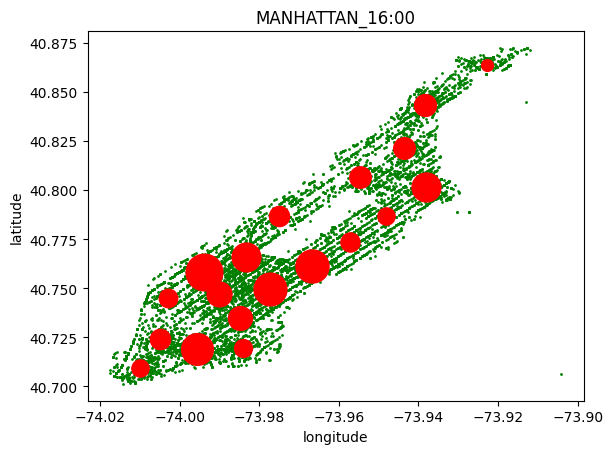

In [71]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.9:
        if i[0]>40.70 and i[0]<40.90:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if j[1]>-74.05 and j[1]<-73.9:
        if j[0]>40.70 and j[0]<40.90:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("MANHATTAN_16:00")

In [72]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.773464742270534, -73.95711191231884, 414],
 [40.70938672749326, -74.01000166334232, 371],
 [40.84350822510548, -73.93832732721518, 474],
 [40.75814868787879, -73.99387734760101, 791],
 [40.78699525483871, -73.94805319112903, 372],
 [40.86382633267717, -73.9227524023622, 254],
 [40.74977592679831, -73.97722322129759, 708],
 [40.80654465862069, -73.95470241508622, 464],
 [40.801550514903845, -73.93801231826924, 624],
 [40.73490252226563, -73.98486043164061, 515],
 [40.74699686178107, -73.9901561549165, 536],
 [40.723951409817346, -74.00492994885845, 438],
 [40.82152041738197, -73.94360652446352, 466],
 [40.761328825490196, -73.96676534551821, 714],
 [40.78665570229885, -73.97503505747126, 435],
 [40.76614625176849, -73.98318346832797, 622],
 [40.71937863617572, -73.98413637131783, 387],
 [40.71905419109489, -73.99562985839417, 685],
 [40.74505415879397, -74.00281248869348, 400],
 [40.769688, -73.736305, 1]]

### 17:00

In [73]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='17:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="MANHATTAN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+---------+--------+--------------------+
| latitude| longitude|  borough|    time|            features|
+---------+----------+---------+--------+--------------------+
| 40.76551| -73.97795|MANHATTAN|17:00:00|[40.76551,-73.97795]|
|40.715477|-73.998085|MANHATTAN|17:00:00|[40.715477,-73.99...|
| 40.79194| -73.95281|MANHATTAN|17:00:00|[40.79194,-73.95281]|
|40.718792| -73.98902|MANHATTAN|17:00:00|[40.718792,-73.98...|
| 40.72538| -74.00011|MANHATTAN|17:00:00|[40.72538,-74.00011]|
| 40.72728| -73.97906|MANHATTAN|17:00:00|[40.72728,-73.97906]|
| 40.74652| -73.99388|MANHATTAN|17:00:00|[40.74652,-73.99388]|
| 40.80153| -73.93669|MANHATTAN|17:00:00|[40.80153,-73.93669]|
|40.719055| -74.01245|MANHATTAN|17:00:00|[40.719055,-74.01...|
|40.783146| -73.97833|MANHATTAN|17:00:00|[40.783146,-73.97...|
|40.762287| -73.97027|MANHATTAN|17:00:00|[40.762287,-73.97...|
|40.815205|-73.947495|MANHATTAN|17:00:00|[40.815205,-73.94...|
| 40.75524| -73.97328|MANHATTAN|17:00:00|[40.75524,-73.

In [74]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+---------+--------+--------------------+----------+
| latitude| longitude|  borough|    time|            features|prediction|
+---------+----------+---------+--------+--------------------+----------+
| 40.76551| -73.97795|MANHATTAN|17:00:00|[40.76551,-73.97795]|         0|
|40.715477|-73.998085|MANHATTAN|17:00:00|[40.715477,-73.99...|         2|
| 40.79194| -73.95281|MANHATTAN|17:00:00|[40.79194,-73.95281]|        16|
|40.718792| -73.98902|MANHATTAN|17:00:00|[40.718792,-73.98...|        14|
| 40.72538| -74.00011|MANHATTAN|17:00:00|[40.72538,-74.00011]|         8|
| 40.72728| -73.97906|MANHATTAN|17:00:00|[40.72728,-73.97906]|        14|
| 40.74652| -73.99388|MANHATTAN|17:00:00|[40.74652,-73.99388]|        19|
| 40.80153| -73.93669|MANHATTAN|17:00:00|[40.80153,-73.93669]|        12|
|40.719055| -74.01245|MANHATTAN|17:00:00|[40.719055,-74.01...|         9|
|40.783146| -73.97833|MANHATTAN|17:00:00|[40.783146,-73.97...|        13|
|40.762287| -73.97027|MANHATTAN|17:00:

Text(0.5, 1.0, 'MANHATTAN_17:00')

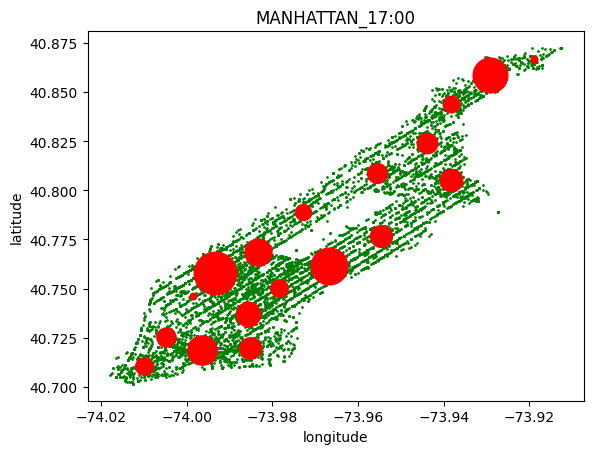

In [75]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.9:
        if i[0]>40.70 and i[0]<40.90:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if j[1]>-74.05 and j[1]<-73.9:
        if j[0]>40.70 and j[0]<40.90:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("MANHATTAN_17:00")

In [76]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.76838825866209, -73.98335680205832, 582],
 [40.84378914472222, -73.93834449666666, 360],
 [40.71876775671405, -73.99640702274881, 633],
 [40.80880575399062, -73.95563919671362, 428],
 [40.77657097231405, -73.95474729194214, 472],
 [40.82396633455378, -73.9439908576659, 441],
 [40.75780479075081, -73.9934865945593, 919],
 [40.76164752262958, -73.96681850695325, 791],
 [40.72537381694916, -74.00493945205811, 413],
 [40.71059265052631, -74.01011850526316, 380],
 [40.866688822068966, -73.91898827862069, 145],
 [40.737003110476195, -73.98581987161906, 525],
 [40.80518847193347, -73.9382929889813, 482],
 [40.789162405507255, -73.97275921971014, 346],
 [40.71985903866091, -73.98535477926566, 463],
 [40.609938, -73.96416500000001, 2],
 [40.793009811621616, -73.94306020351353, 375],
 [40.750483433733336, -73.97858747439999, 750],
 [40.858598965492966, -73.92918369788732, 142],
 [40.746157904601766, -73.99864947964602, 565]]

### 18:00

In [77]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='18:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="MANHATTAN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+------------------+---------+--------+--------------------+
| latitude|         longitude|  borough|    time|            features|
+---------+------------------+---------+--------+--------------------+
|40.766502|         -73.99418|MANHATTAN|18:00:00|[40.766502,-73.99...|
|40.812912|-73.95364000000001|MANHATTAN|18:00:00|[40.812912,-73.95...|
| 40.74668|         -73.98586|MANHATTAN|18:00:00|[40.74668,-73.98586]|
|40.841152|        -73.942696|MANHATTAN|18:00:00|[40.841152,-73.94...|
|40.821583|         -73.94849|MANHATTAN|18:00:00|[40.821583,-73.94...|
| 40.75613|         -73.96761|MANHATTAN|18:00:00|[40.75613,-73.96761]|
|40.814575|         -73.95539|MANHATTAN|18:00:00|[40.814575,-73.95...|
| 40.84931|         -73.93002|MANHATTAN|18:00:00|[40.84931,-73.93002]|
|40.814186|         -73.95087|MANHATTAN|18:00:00|[40.814186,-73.95...|
|40.787838|         -73.97752|MANHATTAN|18:00:00|[40.787838,-73.97...|
|40.771954|        -73.958984|MANHATTAN|18:00:00|[40.771954,-73.95...|
|40.81

In [78]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+------------------+---------+--------+--------------------+----------+
| latitude|         longitude|  borough|    time|            features|prediction|
+---------+------------------+---------+--------+--------------------+----------+
|40.766502|         -73.99418|MANHATTAN|18:00:00|[40.766502,-73.99...|        12|
|40.812912|-73.95364000000001|MANHATTAN|18:00:00|[40.812912,-73.95...|        13|
| 40.74668|         -73.98586|MANHATTAN|18:00:00|[40.74668,-73.98586]|         0|
|40.841152|        -73.942696|MANHATTAN|18:00:00|[40.841152,-73.94...|         9|
|40.821583|         -73.94849|MANHATTAN|18:00:00|[40.821583,-73.94...|         7|
| 40.75613|         -73.96761|MANHATTAN|18:00:00|[40.75613,-73.96761]|        14|
|40.814575|         -73.95539|MANHATTAN|18:00:00|[40.814575,-73.95...|        13|
| 40.84931|         -73.93002|MANHATTAN|18:00:00|[40.84931,-73.93002]|         2|
|40.814186|         -73.95087|MANHATTAN|18:00:00|[40.814186,-73.95...|        13|
|40.787838|     

Text(0.5, 1.0, 'MANHATTAN_18:00')

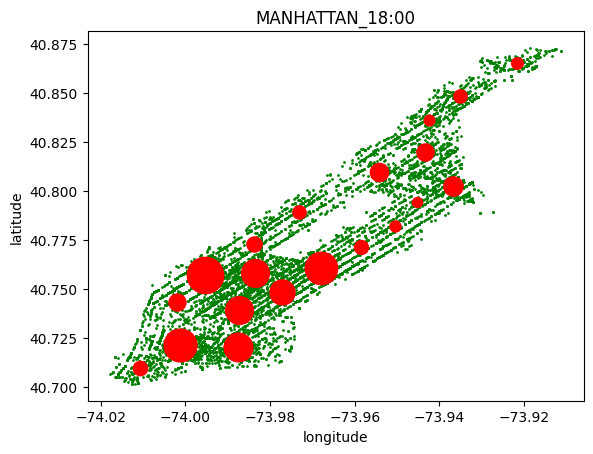

In [79]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.9:
        if i[0]>40.70 and i[0]<40.90:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if j[1]>-74.05 and j[1]<-73.9:
        if j[0]>40.70 and j[0]<40.90:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("MANHATTAN_18:00")

In [80]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.739116756093495, -73.98726966644406, 599],
 [40.72016604200323, -73.98766339176089, 619],
 [40.84861800807019, -73.93512090982455, 285],
 [40.77129255133333, -73.95846760166667, 300],
 [40.80228442337351, -73.93685535325302, 415],
 [40.77288752331288, -73.98368105644174, 326],
 [40.78219854100417, -73.9503839217573, 239],
 [40.82009768216216, -73.94339915621622, 370],
 [40.794381701357466, -73.94529914208145, 216],
 [40.8361181838428, -73.9424553393013, 229],
 [40.721359001551484, -74.0013736754584, 709],
 [40.8651231908, -73.9217215172, 250],
 [40.7569307077707, -73.99542114917197, 785],
 [40.809464496658094, -73.95435292159382, 394],
 [40.760671954871064, -73.96799472851002, 699],
 [40.743354753260874, -74.0020640111413, 368],
 [40.748244170609986, -73.97708026487985, 540],
 [40.78946710979021, -73.97304916118881, 286],
 [40.70985687, -74.01078126806452, 310],
 [40.75832389382305, -73.98355457846411, 599]]

### 19:00

In [81]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='19:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="MANHATTAN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+---------+--------+--------------------+
| latitude| longitude|  borough|    time|            features|
+---------+----------+---------+--------+--------------------+
| 40.76175| -73.96899|MANHATTAN|19:00:00|[40.76175,-73.96899]|
|40.730145| -73.99781|MANHATTAN|19:00:00|[40.730145,-73.99...|
|40.762966|-73.973976|MANHATTAN|19:00:00|[40.762966,-73.97...|
|40.738316| -73.98773|MANHATTAN|19:00:00|[40.738316,-73.98...|
|40.800972|-73.947174|MANHATTAN|19:00:00|[40.800972,-73.94...|
|40.741028| -73.99417|MANHATTAN|19:00:00|[40.741028,-73.99...|
|40.764614| -73.95833|MANHATTAN|19:00:00|[40.764614,-73.95...|
|40.792126| -73.97178|MANHATTAN|19:00:00|[40.792126,-73.97...|
|40.724968| -74.00158|MANHATTAN|19:00:00|[40.724968,-74.00...|
|40.804054| -73.93664|MANHATTAN|19:00:00|[40.804054,-73.93...|
|40.820095|-73.955086|MANHATTAN|19:00:00|[40.820095,-73.95...|
|40.738247| -73.98066|MANHATTAN|19:00:00|[40.738247,-73.98...|
|40.760536| -73.95836|MANHATTAN|19:00:00|[40.760536,-73

In [82]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+---------+--------+--------------------+----------+
| latitude| longitude|  borough|    time|            features|prediction|
+---------+----------+---------+--------+--------------------+----------+
| 40.76175| -73.96899|MANHATTAN|19:00:00|[40.76175,-73.96899]|         7|
|40.730145| -73.99781|MANHATTAN|19:00:00|[40.730145,-73.99...|        11|
|40.762966|-73.973976|MANHATTAN|19:00:00|[40.762966,-73.97...|         7|
|40.738316| -73.98773|MANHATTAN|19:00:00|[40.738316,-73.98...|        10|
|40.800972|-73.947174|MANHATTAN|19:00:00|[40.800972,-73.94...|        14|
|40.741028| -73.99417|MANHATTAN|19:00:00|[40.741028,-73.99...|        10|
|40.764614| -73.95833|MANHATTAN|19:00:00|[40.764614,-73.95...|         7|
|40.792126| -73.97178|MANHATTAN|19:00:00|[40.792126,-73.97...|        15|
|40.724968| -74.00158|MANHATTAN|19:00:00|[40.724968,-74.00...|        11|
|40.804054| -73.93664|MANHATTAN|19:00:00|[40.804054,-73.93...|        13|
|40.820095|-73.955086|MANHATTAN|19:00:

Text(0.5, 1.0, 'MANHATTAN_19:00')

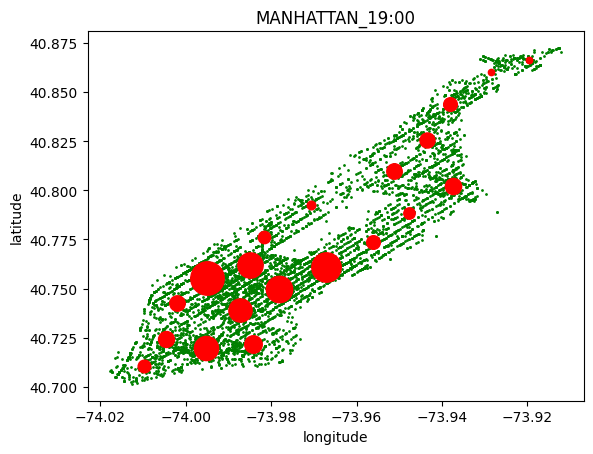

In [83]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.9:
        if i[0]>40.70 and i[0]<40.90:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if j[1]>-74.05 and j[1]<-73.9:
        if j[0]>40.70 and j[0]<40.90:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("MANHATTAN_19:00")

In [84]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.74242776279762, -74.00206948839286, 334],
 [40.84384280375427, -73.93814417508531, 295],
 [40.78817379306123, -73.94763062000003, 247],
 [40.776428116104874, -73.98156644419477, 267],
 [40.710610174909085, -74.00967183127273, 275],
 [40.7196619545977, -73.99528228199235, 522],
 [40.76187539981685, -73.98499653772893, 546],
 [40.761003196220464, -73.96703595795275, 635],
 [40.749657410193315, -73.97807863848858, 569],
 [40.866486731159426, -73.91963816449275, 140],
 [40.73926284083665, -73.98725630836653, 502],
 [40.7241124186589, -74.0046285930029, 345],
 [40.75548618171746, -73.9949085530471, 722],
 [40.802007613068184, -73.93741006789772, 351],
 [40.80986077357357, -73.95116750660661, 334],
 [40.792497774866305, -73.97064986737968, 187],
 [40.8598834762963, -73.92856165037036, 136],
 [40.7215584403694, -73.98419898496041, 379],
 [40.825297234242434, -73.94344110636362, 326],
 [40.773873078523486, -73.95609057885905, 295]]

### 20:00

In [85]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='20:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="MANHATTAN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+---------+--------+--------------------+
| latitude| longitude|  borough|    time|            features|
+---------+----------+---------+--------+--------------------+
|40.718662| -74.00615|MANHATTAN|20:00:00|[40.718662,-74.00...|
| 40.76649| -73.95696|MANHATTAN|20:00:00|[40.76649,-73.95696]|
|40.841717| -73.94435|MANHATTAN|20:00:00|[40.841717,-73.94...|
|40.767967| -73.96822|MANHATTAN|20:00:00|[40.767967,-73.96...|
|40.848736| -73.93234|MANHATTAN|20:00:00|[40.848736,-73.93...|
|40.783245| -73.94473|MANHATTAN|20:00:00|[40.783245,-73.94...|
| 40.79166| -73.96469|MANHATTAN|20:00:00|[40.79166,-73.96469]|
| 40.83468|-73.944435|MANHATTAN|20:00:00|[40.83468,-73.944...|
|40.752052|-74.000984|MANHATTAN|20:00:00|[40.752052,-74.00...|
| 40.70793|-74.015564|MANHATTAN|20:00:00|[40.70793,-74.015...|
| 40.71694|-74.016304|MANHATTAN|20:00:00|[40.71694,-74.016...|
| 40.80143| -73.95011|MANHATTAN|20:00:00|[40.80143,-73.95011]|
|40.825783|-73.943474|MANHATTAN|20:00:00|[40.825783,-73

In [86]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+---------+--------+--------------------+----------+
| latitude| longitude|  borough|    time|            features|prediction|
+---------+----------+---------+--------+--------------------+----------+
|40.718662| -74.00615|MANHATTAN|20:00:00|[40.718662,-74.00...|         4|
| 40.76649| -73.95696|MANHATTAN|20:00:00|[40.76649,-73.95696]|        12|
|40.841717| -73.94435|MANHATTAN|20:00:00|[40.841717,-73.94...|        11|
|40.767967| -73.96822|MANHATTAN|20:00:00|[40.767967,-73.96...|        12|
|40.848736| -73.93234|MANHATTAN|20:00:00|[40.848736,-73.93...|        11|
|40.783245| -73.94473|MANHATTAN|20:00:00|[40.783245,-73.94...|         7|
| 40.79166| -73.96469|MANHATTAN|20:00:00|[40.79166,-73.96469]|         3|
| 40.83468|-73.944435|MANHATTAN|20:00:00|[40.83468,-73.944...|         6|
|40.752052|-74.000984|MANHATTAN|20:00:00|[40.752052,-74.00...|         5|
| 40.70793|-74.015564|MANHATTAN|20:00:00|[40.70793,-74.015...|         4|
| 40.71694|-74.016304|MANHATTAN|20:00:

Text(0.5, 1.0, 'MANHATTAN_20:00')

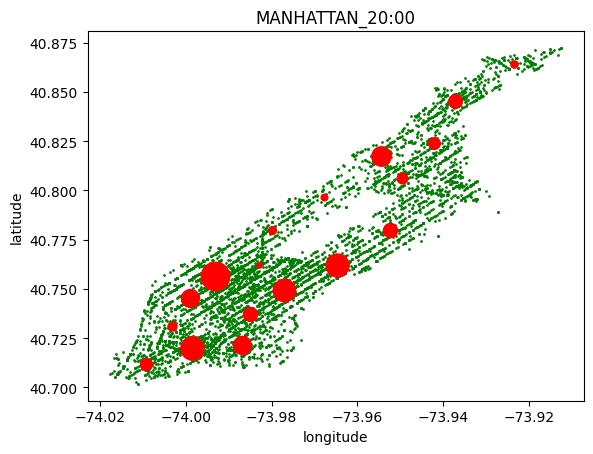

In [87]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.9:
        if i[0]>40.70 and i[0]<40.90:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if j[1]>-74.05 and j[1]<-73.9:
        if j[0]>40.70 and j[0]<40.90:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("MANHATTAN_20:00")

In [88]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.73140966335079, -74.0031655895288, 196],
 [40.864065024358965, -73.9235106198718, 156],
 [40.756602836585365, -73.99327130682929, 615],
 [40.79660262986112, -73.9678705375, 144],
 [40.71197086293436, -74.0092875057915, 261],
 [40.745248051679596, -73.99904265271319, 388],
 [40.8239201940239, -73.94211168725099, 251],
 [40.77980137236841, -73.9523006049342, 304],
 [40.749555481404954, -73.97707228119835, 484],
 [40.78011616374269, -73.97978735730993, 171],
 [40.80643395714286, -73.94955038398268, 231],
 [40.845318707770275, -73.93733003175674, 296],
 [40.76212582736419, -73.96473997022133, 497],
 [40.721468164795915, -73.98686403061225, 391],
 [40.72018535287128, -73.99862125920792, 502],
 [40.690965, -73.827965, 2],
 [40.79969114983606, -73.93881160590163, 305],
 [40.737527459669806, -73.98495350896225, 420],
 [40.81748722300885, -73.95444197256637, 113],
 [40.76238669672802, -73.9827976817996, 489]]

### 21:00

In [89]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='21:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="MANHATTAN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+---------+--------+--------------------+
| latitude| longitude|  borough|    time|            features|
+---------+----------+---------+--------+--------------------+
|40.798286|-73.938705|MANHATTAN|21:00:00|[40.798286,-73.93...|
| 40.77733| -73.95456|MANHATTAN|21:00:00|[40.77733,-73.95456]|
|40.751442| -73.97606|MANHATTAN|21:00:00|[40.751442,-73.97...|
|40.710697|-73.984634|MANHATTAN|21:00:00|[40.710697,-73.98...|
| 40.79335| -73.97275|MANHATTAN|21:00:00|[40.79335,-73.97275]|
| 40.75964| -73.95817|MANHATTAN|21:00:00|[40.75964,-73.95817]|
| 40.80889| -73.95581|MANHATTAN|21:00:00|[40.80889,-73.95581]|
|40.845467|-73.940475|MANHATTAN|21:00:00|[40.845467,-73.94...|
|40.802696|-73.949196|MANHATTAN|21:00:00|[40.802696,-73.94...|
| 40.75781| -73.97353|MANHATTAN|21:00:00|[40.75781,-73.97353]|
|40.744747| -73.99717|MANHATTAN|21:00:00|[40.744747,-73.99...|
| 40.76979|-73.988075|MANHATTAN|21:00:00|[40.76979,-73.988...|
| 40.83112|  -73.9419|MANHATTAN|21:00:00| [40.83112,-73

In [90]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+---------+--------+--------------------+----------+
| latitude| longitude|  borough|    time|            features|prediction|
+---------+----------+---------+--------+--------------------+----------+
|40.798286|-73.938705|MANHATTAN|21:00:00|[40.798286,-73.93...|         9|
| 40.77733| -73.95456|MANHATTAN|21:00:00|[40.77733,-73.95456]|        15|
|40.751442| -73.97606|MANHATTAN|21:00:00|[40.751442,-73.97...|        14|
|40.710697|-73.984634|MANHATTAN|21:00:00|[40.710697,-73.98...|         7|
| 40.79335| -73.97275|MANHATTAN|21:00:00|[40.79335,-73.97275]|         0|
| 40.75964| -73.95817|MANHATTAN|21:00:00|[40.75964,-73.95817]|         2|
| 40.80889| -73.95581|MANHATTAN|21:00:00|[40.80889,-73.95581]|        10|
|40.845467|-73.940475|MANHATTAN|21:00:00|[40.845467,-73.94...|        12|
|40.802696|-73.949196|MANHATTAN|21:00:00|[40.802696,-73.94...|        10|
| 40.75781| -73.97353|MANHATTAN|21:00:00|[40.75781,-73.97353]|         2|
|40.744747| -73.99717|MANHATTAN|21:00:

Text(0.5, 1.0, 'MANHATTAN_21:00')

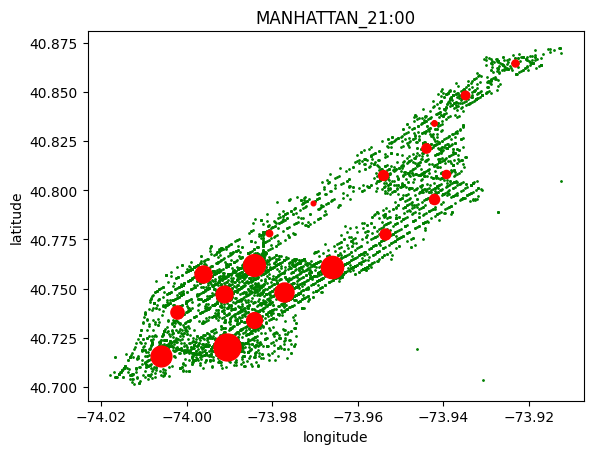

In [91]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.9:
        if i[0]>40.70 and i[0]<40.90:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if j[1]>-74.05 and j[1]<-73.9:
        if j[0]>40.70 and j[0]<40.90:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("MANHATTAN_21:00")

In [92]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.793295278, -73.97052368000001, 100],
 [40.71564202271715, -74.00612801737194, 449],
 [40.760929605613306, -73.96610180893971, 481],
 [40.864463607894734, -73.92310498421051, 153],
 [40.747081215426995, -73.9912253969697, 363],
 [40.82161547733991, -73.94393939950739, 202],
 [40.733889852058816, -73.98419867, 340],
 [40.7202741161512, -73.99050488814434, 582],
 [40.76188687404256, -73.98416650297872, 470],
 [40.79531099819819, -73.94223944504505, 220],
 [40.80778402429906, -73.95400672009347, 214],
 [40.80818688908045, -73.93937277931033, 176],
 [40.848532677005345, -73.93486050053477, 186],
 [40.7379744491228, -74.00221858070176, 285],
 [40.74832120631067, -73.97714379393204, 412],
 [40.77785968902953, -73.95350987130801, 237],
 [40.77820151739132, -73.98064176811596, 138],
 [40.75740421385869, -73.99615786576086, 368],
 [40.834212274576274, -73.94217207881357, 119],
 [40.68257, -73.911653, 3]]

### 22:00

In [93]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='22:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="MANHATTAN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+---------+--------+--------------------+
| latitude| longitude|  borough|    time|            features|
+---------+----------+---------+--------+--------------------+
|40.760822| -73.99832|MANHATTAN|22:00:00|[40.760822,-73.99...|
|40.790417| -73.95184|MANHATTAN|22:00:00|[40.790417,-73.95...|
| 40.76161| -73.97076|MANHATTAN|22:00:00|[40.76161,-73.97076]|
|40.721474| -73.98383|MANHATTAN|22:00:00|[40.721474,-73.98...|
|40.752808| -73.99098|MANHATTAN|22:00:00|[40.752808,-73.99...|
|40.759575| -73.96803|MANHATTAN|22:00:00|[40.759575,-73.96...|
|40.718174| -73.98704|MANHATTAN|22:00:00|[40.718174,-73.98...|
| 40.83349| -73.94158|MANHATTAN|22:00:00|[40.83349,-73.94158]|
|40.755184|  -74.0006|MANHATTAN|22:00:00|[40.755184,-74.0006]|
| 40.79293|-73.950005|MANHATTAN|22:00:00|[40.79293,-73.950...|
|40.720074|-73.988365|MANHATTAN|22:00:00|[40.720074,-73.98...|
| 40.75355| -73.98505|MANHATTAN|22:00:00|[40.75355,-73.98505]|
|40.720192| -73.98737|MANHATTAN|22:00:00|[40.720192,-73

In [94]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+---------+--------+--------------------+----------+
| latitude| longitude|  borough|    time|            features|prediction|
+---------+----------+---------+--------+--------------------+----------+
|40.760822| -73.99832|MANHATTAN|22:00:00|[40.760822,-73.99...|         4|
|40.790417| -73.95184|MANHATTAN|22:00:00|[40.790417,-73.95...|        13|
| 40.76161| -73.97076|MANHATTAN|22:00:00|[40.76161,-73.97076]|         3|
|40.721474| -73.98383|MANHATTAN|22:00:00|[40.721474,-73.98...|         7|
|40.752808| -73.99098|MANHATTAN|22:00:00|[40.752808,-73.99...|        14|
|40.759575| -73.96803|MANHATTAN|22:00:00|[40.759575,-73.96...|         6|
|40.718174| -73.98704|MANHATTAN|22:00:00|[40.718174,-73.98...|         7|
| 40.83349| -73.94158|MANHATTAN|22:00:00|[40.83349,-73.94158]|         8|
|40.755184|  -74.0006|MANHATTAN|22:00:00|[40.755184,-74.0006]|         4|
| 40.79293|-73.950005|MANHATTAN|22:00:00|[40.79293,-73.950...|        13|
|40.720074|-73.988365|MANHATTAN|22:00:

Text(0.5, 1.0, 'MANHATTAN_22:00')

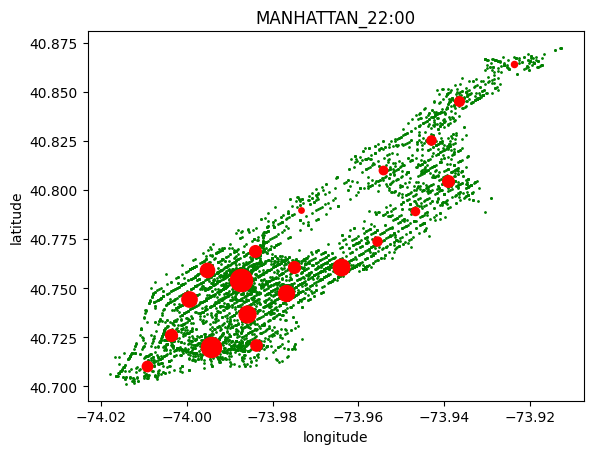

In [95]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.9:
        if i[0]>40.70 and i[0]<40.90:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if j[1]>-74.05 and j[1]<-73.9:
        if j[0]>40.70 and j[0]<40.90:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("MANHATTAN_22:00")

In [96]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.72594134648437, -74.00379630429687, 256],
 [40.86414848863637, -73.92376276060607, 132],
 [40.7739819798969, -73.95571199226804, 196],
 [40.760618218431375, -73.97510959764705, 254],
 [40.75910824675324, -73.99526938474027, 308],
 [40.7368251956044, -73.98588734945055, 364],
 [40.76075744662921, -73.96406548146068, 355],
 [40.72111010122951, -73.98396911967212, 244],
 [40.82541798080808, -73.94293934090909, 198],
 [40.84547460191387, -73.93656995311004, 209],
 [40.71053346488888, -74.00941369200001, 225],
 [40.804495260799996, -73.9390980344, 250],
 [40.81029140879121, -73.9543149521978, 182],
 [40.789477837142854, -73.94676867199999, 175],
 [40.75399923807531, -73.9873119416318, 478],
 [40.78964873275862, -73.97343115086207, 116],
 [40.769151820553354, -73.98405832806323, 253],
 [40.720191927083334, -73.99429875532407, 432],
 [40.744293074924464, -73.99962216646524, 331],
 [40.74737839534883, -73.97677783604651, 344]]

### 23:00

In [97]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='23:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="MANHATTAN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+---------+--------+--------------------+
| latitude| longitude|  borough|    time|            features|
+---------+----------+---------+--------+--------------------+
| 40.72224|  -73.9863|MANHATTAN|23:00:00| [40.72224,-73.9863]|
| 40.75584| -73.99238|MANHATTAN|23:00:00|[40.75584,-73.99238]|
|40.795006|  -73.9485|MANHATTAN|23:00:00|[40.795006,-73.9485]|
|40.734886| -73.98995|MANHATTAN|23:00:00|[40.734886,-73.98...|
|40.818474| -73.95332|MANHATTAN|23:00:00|[40.818474,-73.95...|
|40.709835|-74.014885|MANHATTAN|23:00:00|[40.709835,-74.01...|
|40.809525| -73.93789|MANHATTAN|23:00:00|[40.809525,-73.93...|
|40.753242| -73.96662|MANHATTAN|23:00:00|[40.753242,-73.96...|
|40.718044| -73.99605|MANHATTAN|23:00:00|[40.718044,-73.99...|
|40.715557| -73.99826|MANHATTAN|23:00:00|[40.715557,-73.99...|
|40.794758| -73.94235|MANHATTAN|23:00:00|[40.794758,-73.94...|
|40.822834|-73.941925|MANHATTAN|23:00:00|[40.822834,-73.94...|
|40.752377| -73.97035|MANHATTAN|23:00:00|[40.752377,-73

In [98]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+---------+--------+--------------------+----------+
| latitude| longitude|  borough|    time|            features|prediction|
+---------+----------+---------+--------+--------------------+----------+
| 40.72224|  -73.9863|MANHATTAN|23:00:00| [40.72224,-73.9863]|        15|
| 40.75584| -73.99238|MANHATTAN|23:00:00|[40.75584,-73.99238]|        14|
|40.795006|  -73.9485|MANHATTAN|23:00:00|[40.795006,-73.9485]|         4|
|40.734886| -73.98995|MANHATTAN|23:00:00|[40.734886,-73.98...|        11|
|40.818474| -73.95332|MANHATTAN|23:00:00|[40.818474,-73.95...|         8|
|40.709835|-74.014885|MANHATTAN|23:00:00|[40.709835,-74.01...|         7|
|40.809525| -73.93789|MANHATTAN|23:00:00|[40.809525,-73.93...|         4|
|40.753242| -73.96662|MANHATTAN|23:00:00|[40.753242,-73.96...|         9|
|40.718044| -73.99605|MANHATTAN|23:00:00|[40.718044,-73.99...|         5|
|40.715557| -73.99826|MANHATTAN|23:00:00|[40.715557,-73.99...|         5|
|40.794758| -73.94235|MANHATTAN|23:00:

Text(0.5, 1.0, 'MANHATTAN_23:00')

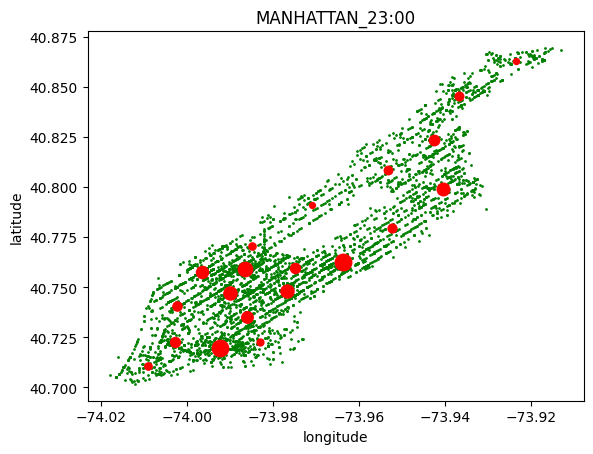

In [99]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.9:
        if i[0]>40.70 and i[0]<40.90:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if j[1]>-74.05 and j[1]<-73.9:
        if j[0]>40.70 and j[0]<40.90:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/30)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("MANHATTAN_23:00")

In [100]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.748026026428576, -73.97677718857145, 282],
 [40.86299249076924, -73.92355058153845, 130],
 [40.79077901904762, -73.97091331349206, 126],
 [40.75911840584415, -73.98653895, 308],
 [40.798954937867656, -73.9404189632353, 272],
 [40.719727052974505, -73.9924568835694, 353],
 [40.77934155863874, -73.9524584643979, 191],
 [40.71047818101266, -74.00906185569619, 158],
 [40.8087517114754, -73.95334038087432, 183],
 [40.762330861624655, -73.96364163557423, 357],
 [40.77063034230768, -73.98492946666667, 156],
 [40.73487675645161, -73.98615017096775, 248],
 [40.82331923511112, -73.94262246266668, 225],
 [40.746951609219856, -73.99001488156028, 283],
 [40.75737841532567, -73.99648321839081, 260],
 [40.722550453333334, -73.98307897266666, 148],
 [40.84566968378378, -73.93667808594596, 185],
 [40.75961521527777, -73.97486160833333, 216],
 [40.722440867441854, -74.00288365720931, 215],
 [40.74030349899498, -74.00229396231155, 199]]